## Multivariate tests

Lets look at how validation metrics change with different inputs and hyper parameters in a one-step lookahead model


# Load data, fucntions

In [ ]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import mean
from numpy import std
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import LSTM
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.layers import TimeDistributed
from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [3]:
def descale_y_retrun_metrics(yhat, y_val2):
    #We will use validation data that has not had outleirs limited, will be a different min/max scaler as such
    pred_descaled= (scaler.inverse_transform(array([yhat,]*(len(inputs))).transpose()[0]))[:, :1]
    groud_truth_descaled= (scaler2.inverse_transform(array([y_val2,]*(len(inputs))).transpose()[0][0]))[ :, :1]
    RMSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)
    MSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=True)
    MAE = mean_absolute_error(groud_truth_descaled, pred_descaled)
    MAPE = mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)
    R2 = r2_score(groud_truth_descaled, pred_descaled)
    return RMSE, MAE, MAPE, R2, MSE

In [4]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out, step_interval):
    X, y = list(), list()
    example_count = int((len(sequence)/step_interval))
    for i in range(example_count):
        # find the end of this pattern
        end_ix = (i*step_interval) + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[(i*step_interval):end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [5]:
percentile_data = pd.read_csv (r'C:\Users/conal/Desktop/MCM/Practicum - Copy/data/block gas price percentile data.csv', header=0)
percentile_data['datetime'] = pd.to_datetime(percentile_data['block_timestamp'], format = '%Y-%m-%d %H:%M:%S UTC')

percentile_data = percentile_data.sort_values(by='datetime',ascending=False)
percentile_data = percentile_data.set_index('datetime')
percentile_data = percentile_data.resample('5T').mean()
percentile_data = percentile_data/1000000000

In [6]:
usage_data = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum - Copy\data\ETH,gas,usage merged 11-26 to 05-26.csv', header=0)
usage_data['datetime'] = pd.to_datetime(usage_data['datetime'], format = '%Y-%m-%d %H:%M:%S')
usage_data = usage_data.set_index('datetime')

usage_data = usage_data.squeeze()
usage_data = usage_data.astype('float')
usage_data = usage_data.resample('5T').mean()


In [7]:
usage_data2 = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum - Copy\data\Contract counts 2021-11-26 to 2022-05-26.csv', header=0, index_col=0)
usage_data2['datetime'] = pd.to_datetime(usage_data2['block_timestamp'], format = '%Y-%m-%d %H:%M:%S') 
usage_data2 = usage_data2.set_index('datetime')
usage_data2 = usage_data2.drop(['block_timestamp'], axis=1)
usage_data2 = usage_data2.squeeze()
usage_data2 = usage_data2.astype('float')
usage_data2 = usage_data2.resample('5T').sum()

In [24]:
data = usage_data.merge(percentile_data, left_index=True, right_index=True)
data = data.merge(usage_data2, left_index=True, right_index=True)

In [25]:
data.tail()

,gas_used,base_fee_per_gas,transaction_count,size,Open,avg_gas_price,max_gas_price,min_gas_price,block_gas_0th_percentile,block_gas_5th_percentile,...,block_gas_50th_percentile,block_gas_60th_percentile,block_gas_70th_percentile,block_gas_80th_percentile,block_gas_90th_percentile,block_gas_95th_percentile,block_gas_100th_percentile,is_erc20,is_erc721,contracts
datetime,,,,,,,,,,,,,,,,,,,,,
2022-04-30 23:35:00,1.687673e+07,72.963036,235.221429,101351.405714,2726.322,82.332828,954.188342,73.042664,72.292214,72.936338,...,73.956988,74.372784,75.737732,78.814915,86.698935,102.025928,1029.215633,0.0,0.0,25.0
2022-04-30 23:40:00,1.923508e+07,81.750621,258.326667,121240.200000,2725.280,93.705296,1544.237339,82.340621,82.707818,83.362540,...,84.101171,84.361139,85.204355,88.106923,96.045722,108.528762,1346.424657,0.0,0.0,19.0
2022-04-30 23:45:00,1.318330e+07,91.284695,181.620000,72564.840000,2724.632,104.494219,1095.301171,91.647416,87.190769,87.961429,...,88.722965,89.155419,90.750518,94.973894,106.761299,123.843003,1079.725532,0.0,0.0,25.0
2022-04-30 23:50:00,1.947184e+07,71.871005,280.966667,111250.066667,2731.438,93.563979,2580.841809,72.495788,74.786744,75.348599,...,76.055971,76.263733,77.048391,82.252036,96.656581,109.511880,1647.642672,0.0,0.0,27.0
2022-04-30 23:55:00,1.650237e+07,66.951502,241.080000,87818.053333,2727.862,75.854503,772.599577,67.504835,66.902647,67.469581,...,68.184466,68.298102,69.044645,73.457054,84.291123,93.296857,833.679712,0.0,0.0,31.0


Load data, datetime to index, downsample with left edge label, convert wei to gwei

In [27]:
def training_split_no_limits(data):    

    data =data[inputs]

    #Filter inputs, set outlier limit
    data =data[inputs]
    scaler2 = StandardScaler()
    data[inputs] = scaler2.fit_transform(data[inputs])


    #Creat input:output examples
    data = data[start_date:end_date].to_numpy()
    X, y = split_sequence(data, n_steps_in, n_steps_out, step_interval)
    X_train2, X_val2 = np.split(X, [int(0.7 * len(X))])
    y_train2, y_val2 = y_train, y_val = np.split(y, [int(0.7 * len(X))])

    #Reshape to 3D for LSTM
    X_train = X_train2.reshape((X_train2.shape[0], X_train2.shape[1], len(inputs)))
    y_train =y_train2.reshape((y_train2.shape[0], y_train2.shape[1], len(inputs)))
    X_val2 = X_val2.reshape((X_val2.shape[0], X_val2.shape[1], len(inputs)))
    y_val2 = y_val2.reshape((y_val2.shape[0], y_val2.shape[1], len(inputs)))
    y_train2 =y_train2[ :, :, :1]
    y_val2 =y_val2[ :, :, :1]
    return X_train2, y_train2, X_val2, y_val2, scaler2

# Lets test some models on only the first month of data to begin with

## Lets try min/max gas block gas price as inputs to begin with

In [44]:
resample_rate = '5T'
start_date='2021-11-26 00:00:00'
end_date='2021-12-26 23:55:00' 
inputs = ['min_gas_price', 'max_gas_price']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 2016
n_steps_out = 1
#How many timesteps between start of training examples
step_interval = 1

In [64]:
X_train, y_train, X_val, y_val, scaler = training_split_no_limits(data)

In [54]:
X_train2, y_train2, X_val2, y_val2, scaler2 = training_split_no_limits(data)

In [65]:
# define model
model = Sequential()
model.add(LSTM(units =15,activation='tanh',input_shape=(n_steps_in, len(inputs)),dropout=0.01))
model.add(Dense(len(inputs)))
opt = keras.optimizers.Adam(learning_rate=0.01, decay=0.0001)
model.compile(optimizer='adam', loss='mse')

In [66]:
model.fit(X_train, y_train, epochs=15, verbose=1, validation_data = (X_val, y_val))

Epoch 1/15
152/152 [==============================] - 11s 59ms/step - loss: 0.5070 - val_loss: 0.0641
Epoch 2/15
152/152 [==============================] - 8s 56ms/step - loss: 0.4270 - val_loss: 0.0567
Epoch 3/15
152/152 [==============================] - 8s 55ms/step - loss: 0.3838 - val_loss: 0.0550
Epoch 4/15
152/152 [==============================] - 8s 54ms/step - loss: 0.3496 - val_loss: 0.0504
Epoch 5/15
152/152 [==============================] - 8s 56ms/step - loss: 0.3401 - val_loss: 0.0506
Epoch 6/15
152/152 [==============================] - 8s 56ms/step - loss: 0.3048 - val_loss: 0.0451
Epoch 7/15
152/152 [==============================] - 8s 55ms/step - loss: 0.2891 - val_loss: 0.0454
Epoch 8/15
152/152 [==============================] - 8s 56ms/step - loss: 0.2784 - val_loss: 0.0445
Epoch 9/15
152/152 [==============================] - 8s 56ms/step - loss: 0.2676 - val_loss: 0.0433
Epoch 10/15
152/152 [==============================] - 8s 55ms/step - loss: 0.2660 - val_l

Trainign stopped early as model stopped learning

In [67]:
yhat = model.predict(X_val, verbose=1)

65/65 [==============================] - 2s 21ms/step


RMSE 12.965259091890596
MAE 7.82647399900014
MAPE 0.11381193185154971
R^2 0.7060135190439429


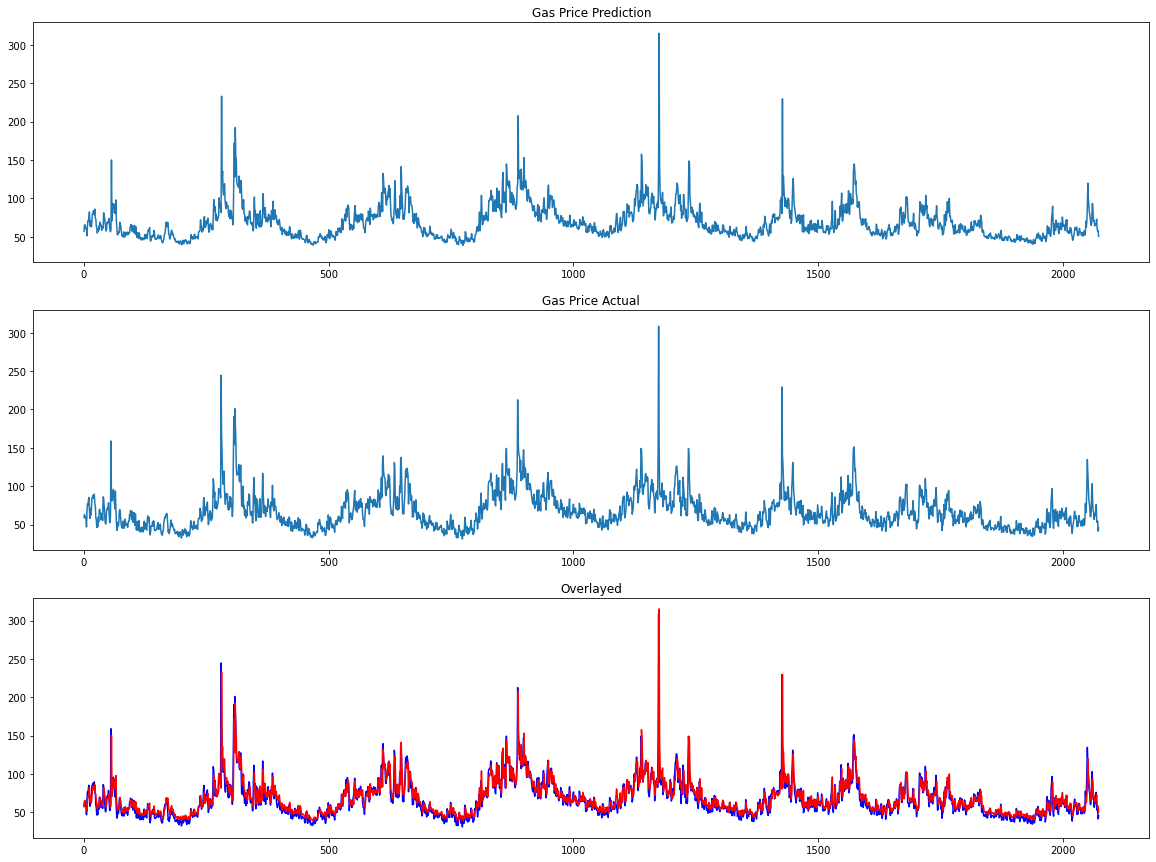

In [69]:
#Minmax scaler has been fit with 2d data, 
pred_descaled= (scaler.inverse_transform(array([yhat,]*len(inputs)).transpose()[0]))[:, :1]
groud_truth_descaled= (scaler2.inverse_transform(array([y_val2,]*len(inputs)).transpose()[0][0]))[ :, :1]


f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)
f.set_figwidth(20)
f.set_figheight(15)
ax1.plot(pred_descaled)
ax1.title.set_text('Gas Price Prediction')
ax2.plot(groud_truth_descaled)
ax2.title.set_text('Gas Price Actual')


ax3.title.set_text('Overlayed')
ax3.plot(groud_truth_descaled, color='blue',label='Predicted '+' Gas Price')
ax3.plot(pred_descaled, color='red',label='real '+' Gas Price')



print('RMSE ' + str(mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)))
print('MAE ' + str(mean_absolute_error(groud_truth_descaled, pred_descaled)))
print('MAPE ' + str(mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)))
print('R^2 ' + str(r2_score(groud_truth_descaled, pred_descaled)))

## Lets try 5th/95th percentile of block gas price as inputs


In [15]:
resample_rate = '5T'
start_date='2021-11-26 00:00:00'
end_date='2021-12-26 23:55:00' 
inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 2016
n_steps_out = 1
#How many timesteps between start of training examples
step_interval = 1


X_train, y_train, X_val, y_val, scaler = training_split_no_limits(data)
X_train2, y_train2, X_val2, y_val2, scaler2 = training_split_no_limits(data)

In [ ]:
# define model
model = Sequential()
model.add(LSTM(units =15,activation='tanh',input_shape=(n_steps_in, len(inputs)),dropout=0.01))
model.add(Dense(len(inputs)))
opt = keras.optimizers.Adam(learning_rate=0.01, decay=0.0001)
model.compile(optimizer='adam', loss='mse')

In [83]:
model.fit(X_train2, y_train2, epochs=15, verbose=1, validation_data=(X_val2, y_val2))

Epoch 1/15
152/152 [==============================] - 11s 60ms/step - loss: 0.5652 - val_loss: 0.0581
Epoch 2/15
152/152 [==============================] - 8s 55ms/step - loss: 0.4267 - val_loss: 0.0522
Epoch 3/15
152/152 [==============================] - 9s 59ms/step - loss: 0.3737 - val_loss: 0.0464
Epoch 4/15
152/152 [==============================] - 9s 57ms/step - loss: 0.3327 - val_loss: 0.0444
Epoch 5/15
152/152 [==============================] - 8s 54ms/step - loss: 0.3109 - val_loss: 0.0460
Epoch 6/15
152/152 [==============================] - 8s 55ms/step - loss: 0.2942 - val_loss: 0.0435
Epoch 7/15
152/152 [==============================] - 8s 55ms/step - loss: 0.2867 - val_loss: 0.0462
Epoch 8/15
152/152 [==============================] - 8s 55ms/step - loss: 0.2795 - val_loss: 0.0517
Epoch 9/15
152/152 [==============================] - 9s 56ms/step - loss: 0.2774 - val_loss: 0.0487
Epoch 10/15
152/152 [==============================] - 8s 55ms/step - loss: 0.2712 - val_l

In [84]:
yhat = model.predict(X_val2, verbose=1)

65/65 [==============================] - 2s 24ms/step


Looks like we are getting a uniform prediction with a simple model on multivariate data

RMSE 13.660319522636481
MAE 8.462848618692712
MAPE 0.12582069488142056
R^2 0.6736477016564111


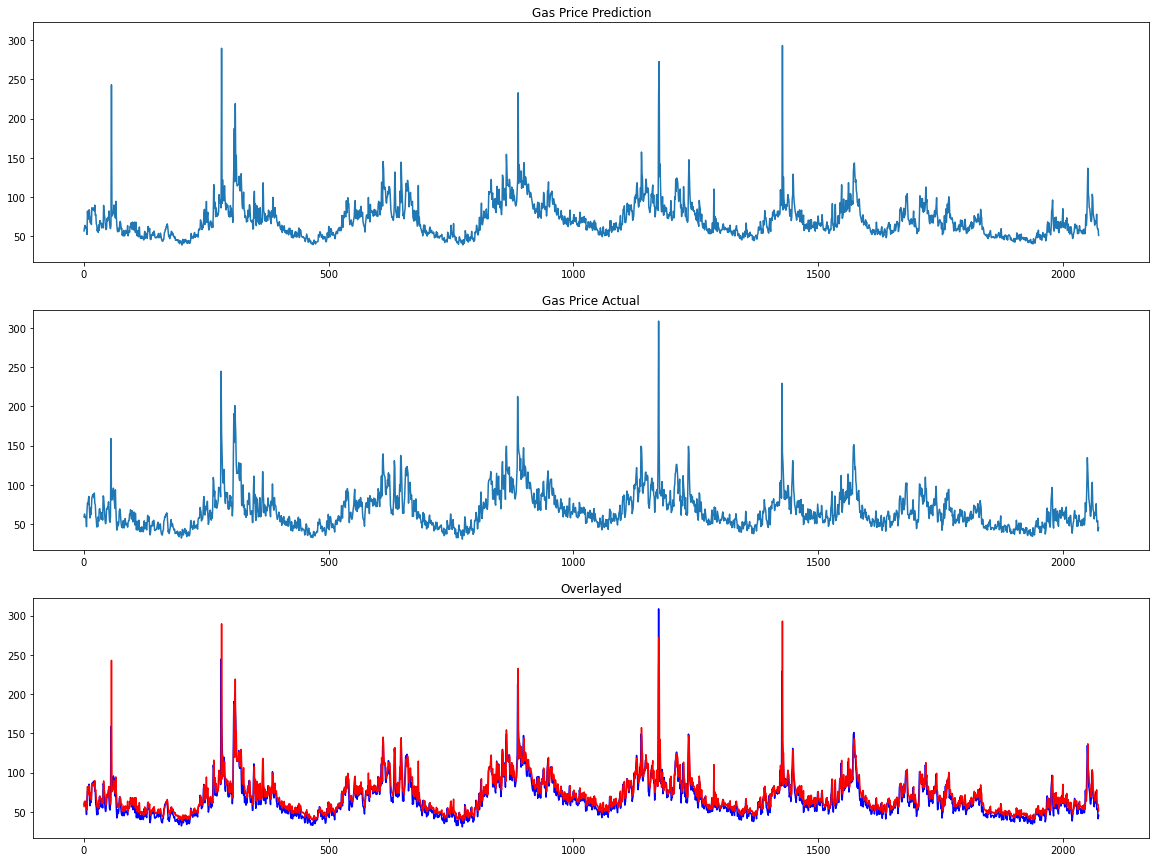

In [86]:
#Minmax scaler has been fit with 2d data, 
pred_descaled= (scaler2.inverse_transform(array([yhat,]*len(inputs)).transpose()[0]))[:, :1]
groud_truth_descaled= (scaler2.inverse_transform(array([y_val2,]*len(inputs)).transpose()[0][0]))[ :, :1]


f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)
f.set_figwidth(20)
f.set_figheight(15)
ax1.plot(pred_descaled)
ax1.title.set_text('Gas Price Prediction')
ax2.plot(groud_truth_descaled)
ax2.title.set_text('Gas Price Actual')


ax3.title.set_text('Overlayed')
ax3.plot(groud_truth_descaled, color='blue',label='Predicted '+' Gas Price')
ax3.plot(pred_descaled, color='red',label='real '+' Gas Price')



print('RMSE ' + str(mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)))
print('MAE ' + str(mean_absolute_error(groud_truth_descaled, pred_descaled)))
print('MAPE ' + str(mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)))
print('R^2 ' + str(r2_score(groud_truth_descaled, pred_descaled)))

## Lets try a smaller example window


In [87]:
resample_rate = '5T'
start_date='2021-11-26 00:00:00'
end_date='2021-12-26 23:55:00' 
inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 1008
n_steps_out = 1
#How many timesteps between start of training examples
step_interval = 1


X_train, y_train, X_val, y_val, scaler = training_split_no_limits(data)
X_train2, y_train2, X_val2, y_val2, scaler2 = training_split_no_limits(data)

In [88]:
# define model
model = Sequential()
model.add(LSTM(units =15,activation='tanh',input_shape=(n_steps_in, len(inputs)),dropout=0.01))
model.add(Dense(len(inputs)))
opt = keras.optimizers.Adam(learning_rate=0.01, decay=0.0001)
model.compile(optimizer='adam', loss='mse')

In [89]:
model.fit(X_train2, y_train2, epochs=15, verbose=1, validation_data=(X_val2, y_val2))

Epoch 1/15
174/174 [==============================] - 9s 35ms/step - loss: 0.6849 - val_loss: 0.1290
Epoch 2/15
174/174 [==============================] - 5s 31ms/step - loss: 0.5254 - val_loss: 0.1146
Epoch 3/15
174/174 [==============================] - 5s 31ms/step - loss: 0.4677 - val_loss: 0.1053
Epoch 4/15
174/174 [==============================] - 5s 31ms/step - loss: 0.4300 - val_loss: 0.0992
Epoch 5/15
174/174 [==============================] - 5s 31ms/step - loss: 0.4036 - val_loss: 0.0974
Epoch 6/15
174/174 [==============================] - 5s 31ms/step - loss: 0.3845 - val_loss: 0.0967
Epoch 7/15
174/174 [==============================] - 5s 31ms/step - loss: 0.3742 - val_loss: 0.0956
Epoch 8/15
174/174 [==============================] - 5s 31ms/step - loss: 0.3630 - val_loss: 0.0982
Epoch 9/15
174/174 [==============================] - 5s 31ms/step - loss: 0.3580 - val_loss: 0.0978
Epoch 10/15
174/174 [==============================] - 5s 31ms/step - loss: 0.3502 - val_lo

In [90]:
yhat = model.predict(X_val2, verbose=1)

75/75 [==============================] - 2s 14ms/step


Looks like we are getting a uniform prediction with a simple model on multivariate data

RMSE 19.281251083263484
MAE 8.044309407573158
MAPE 0.11370654332974339
R^2 0.5180418723582751


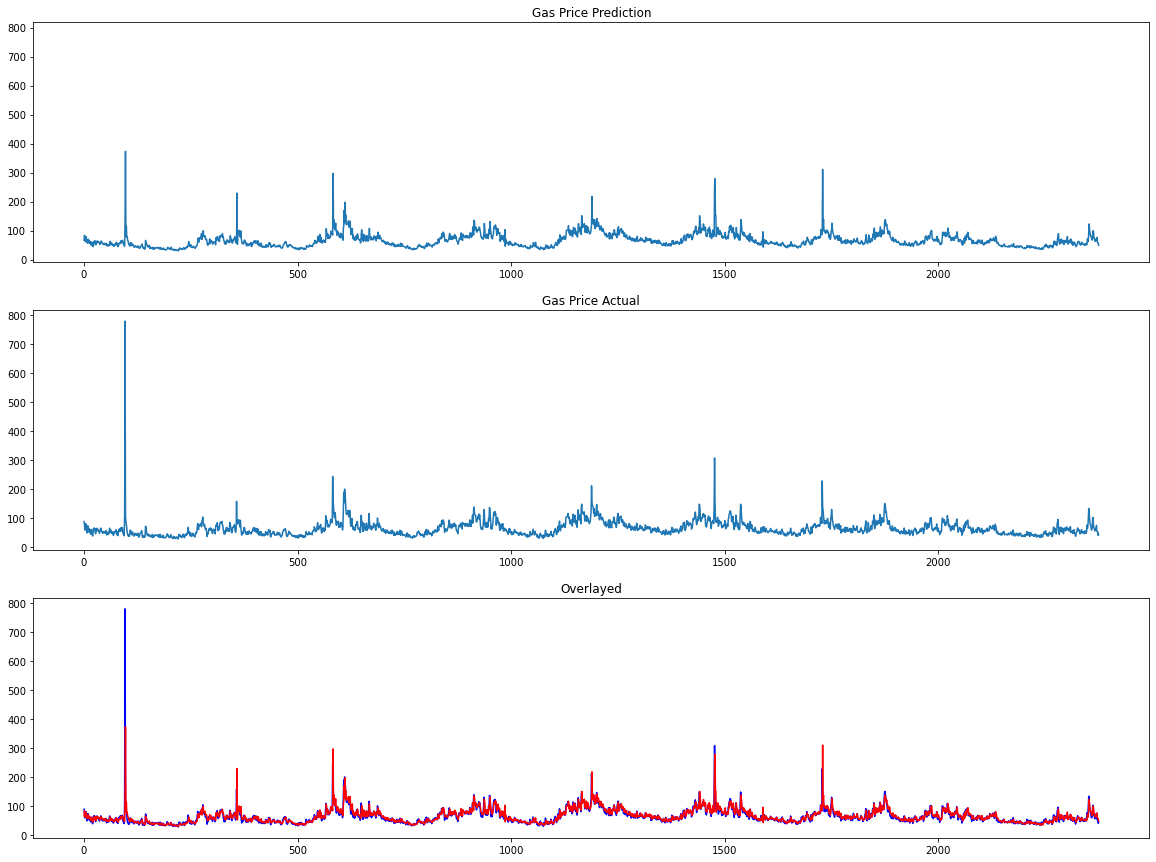

In [92]:
#Minmax scaler has been fit with 2d data, 
pred_descaled= (scaler2.inverse_transform(array([yhat,]*len(inputs)).transpose()[0]))[:, :1]
groud_truth_descaled= (scaler2.inverse_transform(array([y_val2,]*len(inputs)).transpose()[0][0]))[ :, :1]


f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)
f.set_figwidth(20)
f.set_figheight(15)
ax1.plot(pred_descaled)
ax1.title.set_text('Gas Price Prediction')
ax2.plot(groud_truth_descaled)
ax2.title.set_text('Gas Price Actual')


ax3.title.set_text('Overlayed')
ax3.plot(groud_truth_descaled, color='blue',label='Predicted '+' Gas Price')
ax3.plot(pred_descaled, color='red',label='real '+' Gas Price')



print('RMSE ' + str(mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)))
print('MAE ' + str(mean_absolute_error(groud_truth_descaled, pred_descaled)))
print('MAPE ' + str(mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)))
print('R^2 ' + str(r2_score(groud_truth_descaled, pred_descaled)))

In [ ]:
len(inputs)

## Lets try a larger example window


In [104]:
resample_rate = '5T'
start_date='2021-11-26 00:00:00'
end_date='2021-12-26 23:55:00' 
inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 6048
n_steps_out = 1
#How many timesteps between start of training examples
step_interval = 1


X_train, y_train, X_val, y_val, scaler = training_split_no_limits(data)
X_train2, y_train2, X_val2, y_val2, scaler2 = training_split_no_limits(data)

In [105]:
# define model
model = Sequential()
model.add(LSTM(units =15,activation='tanh',input_shape=(n_steps_in, len(inputs)),dropout=0.01))
model.add(Dense(len(inputs)))
opt = keras.optimizers.Adam(learning_rate=0.01, decay=0.0001)
model.compile(optimizer='adam', loss='mse')

In [106]:
model.fit(X_train2, y_train2, epochs=15, verbose=1, validation_data=(X_val2, y_val2))

Epoch 1/15
63/63 [==============================] - 13s 162ms/step - loss: 0.4895 - val_loss: 0.0609
Epoch 2/15
63/63 [==============================] - 10s 153ms/step - loss: 0.3447 - val_loss: 0.0476
Epoch 3/15
63/63 [==============================] - 10s 153ms/step - loss: 0.3313 - val_loss: 0.0484
Epoch 4/15
63/63 [==============================] - 10s 151ms/step - loss: 0.3253 - val_loss: 0.0420
Epoch 5/15
63/63 [==============================] - 10s 152ms/step - loss: 0.3209 - val_loss: 0.0401
Epoch 6/15
63/63 [==============================] - 10s 152ms/step - loss: 0.3165 - val_loss: 0.0404
Epoch 7/15
63/63 [==============================] - 10s 155ms/step - loss: 0.3129 - val_loss: 0.0382
Epoch 8/15
63/63 [==============================] - 9s 151ms/step - loss: 0.3090 - val_loss: 0.0372
Epoch 9/15
63/63 [==============================] - 10s 154ms/step - loss: 0.3051 - val_loss: 0.0368
Epoch 10/15
63/63 [==============================] - 10s 155ms/step - loss: 0.3068 - val_los

In [107]:
yhat = model.predict(X_val2, verbose=1)

28/28 [==============================] - 3s 62ms/step


Looks like we are getting a uniform prediction with a simple model on multivariate data

RMSE 11.034313401248617
MAE 7.272014996614525
MAPE 0.10865945148527713
R^2 0.6730701972097612


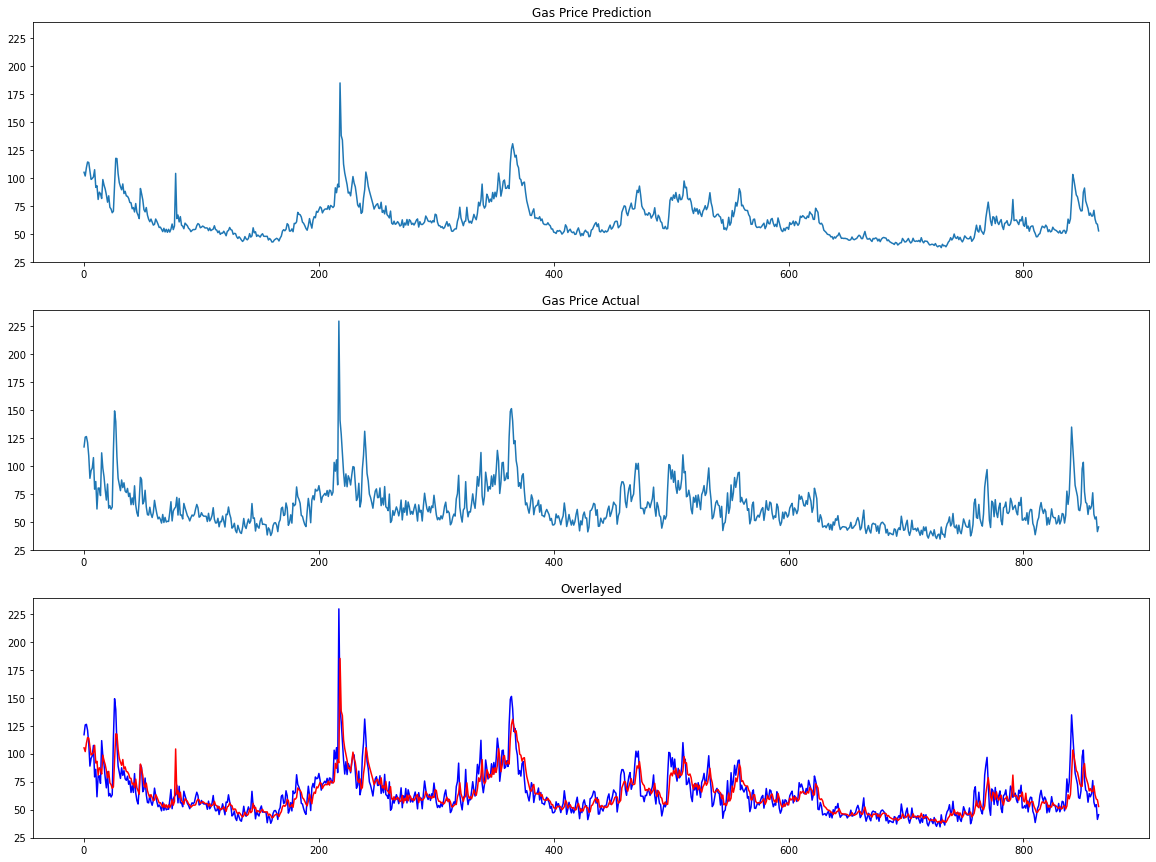

In [108]:
#Minmax scaler has been fit with 2d data, 
pred_descaled= (scaler2.inverse_transform(array([yhat,]*len(inputs)).transpose()[0]))[:, :1]
groud_truth_descaled= (scaler2.inverse_transform(array([y_val2,]*len(inputs)).transpose()[0][0]))[ :, :1]


f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)
f.set_figwidth(20)
f.set_figheight(15)
ax1.plot(pred_descaled)
ax1.title.set_text('Gas Price Prediction')
ax2.plot(groud_truth_descaled)
ax2.title.set_text('Gas Price Actual')


ax3.title.set_text('Overlayed')
ax3.plot(groud_truth_descaled, color='blue',label='Predicted '+' Gas Price')
ax3.plot(pred_descaled, color='red',label='real '+' Gas Price')



print('RMSE ' + str(mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)))
print('MAE ' + str(mean_absolute_error(groud_truth_descaled, pred_descaled)))
print('MAPE ' + str(mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)))
print('R^2 ' + str(r2_score(groud_truth_descaled, pred_descaled)))

## Lets try more data

In [136]:
resample_rate = '5T'
start_date='2021-11-26 00:00:00'
end_date='2022-01-26 23:55:00' 
inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 4032
n_steps_out = 1
#How many timesteps between start of training examples
step_interval = 1


X_train, y_train, X_val, y_val, scaler = training_split_no_limits(data)
X_train2, y_train2, X_val2, y_val2, scaler2 = training_split_no_limits(data)

In [137]:
# define model
model = Sequential()
model.add(LSTM(units =15,activation='tanh',input_shape=(n_steps_in, len(inputs)),dropout=0.01))
model.add(Dense(len(inputs)))
opt = keras.optimizers.Adam(learning_rate=0.01, decay=0.0001)
model.compile(optimizer='adam', loss='mse')


In [138]:
model.fit(X_train2, y_train2, epochs=15, verbose=1, validation_data=(X_val2, y_val2))

Epoch 1/15
303/303 [==============================] - 41s 112ms/step - loss: 0.2488 - val_loss: 0.3423
Epoch 2/15
303/303 [==============================] - 33s 107ms/step - loss: 0.1762 - val_loss: 0.2978
Epoch 3/15
303/303 [==============================] - 33s 108ms/step - loss: 0.1607 - val_loss: 0.2846
Epoch 4/15
303/303 [==============================] - 33s 108ms/step - loss: 0.1565 - val_loss: 0.2812
Epoch 5/15
303/303 [==============================] - 33s 109ms/step - loss: 0.1570 - val_loss: 0.2796
Epoch 6/15
303/303 [==============================] - 32s 107ms/step - loss: 0.1562 - val_loss: 0.2756
Epoch 7/15
303/303 [==============================] - 33s 108ms/step - loss: 0.1536 - val_loss: 0.2722
Epoch 8/15
303/303 [==============================] - 32s 105ms/step - loss: 0.1517 - val_loss: 0.2771
Epoch 9/15
303/303 [==============================] - 32s 106ms/step - loss: 0.1512 - val_loss: 0.2715
Epoch 10/15
303/303 [==============================] - 33s 107ms/step - l

In [139]:
yhat = model.predict(X_val2, verbose=1)

130/130 [==============================] - 6s 41ms/step


RMSE 37.57776702747399
MAE 18.17919819824126
MAPE 0.11512541135504373
R^2 0.6641723863260122


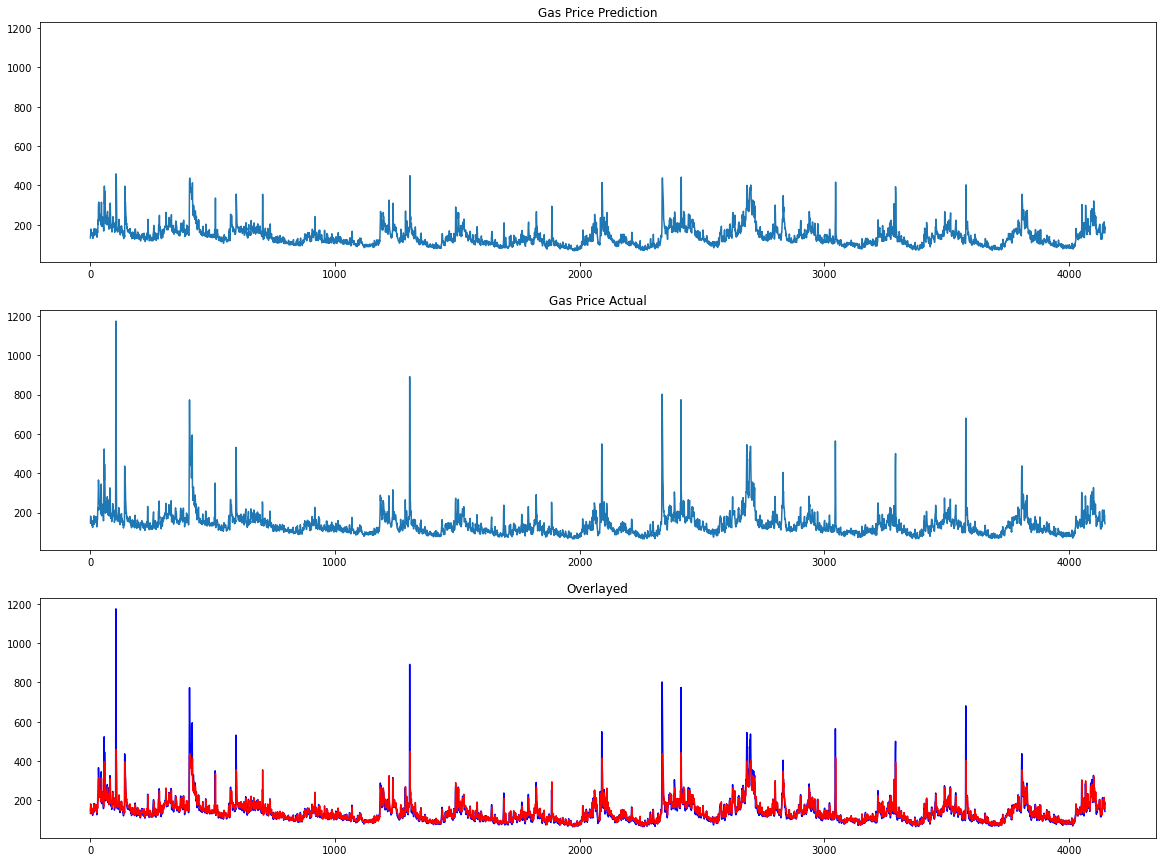

In [141]:
#Minmax scaler has been fit with 2d data, 
pred_descaled= (scaler2.inverse_transform(array([yhat,]*len(inputs)).transpose()[0]))[:, :1]
groud_truth_descaled= (scaler2.inverse_transform(array([y_val2,]*len(inputs)).transpose()[0][0]))[ :, :1]


f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)
f.set_figwidth(20)
f.set_figheight(15)
ax1.plot(pred_descaled)
ax1.title.set_text('Gas Price Prediction')
ax2.plot(groud_truth_descaled)
ax2.title.set_text('Gas Price Actual')


ax3.title.set_text('Overlayed')
ax3.plot(groud_truth_descaled, color='blue',label='Predicted '+' Gas Price')
ax3.plot(pred_descaled, color='red',label='real '+' Gas Price')



print('RMSE ' + str(mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)))
print('MAE ' + str(mean_absolute_error(groud_truth_descaled, pred_descaled)))
print('MAPE ' + str(mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)))
print('R^2 ' + str(r2_score(groud_truth_descaled, pred_descaled)))

## Lets try a more complex model

In [142]:
resample_rate = '5T'
start_date='2021-11-26 00:00:00'
end_date='2022-12-26 23:55:00' 
inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 4032
n_steps_out = 1
#How many timesteps between start of training examples
step_interval = 1


X_train, y_train, X_val, y_val, scaler = training_split_no_limits(data)
X_train2, y_train2, X_val2, y_val2, scaler2 = training_split_no_limits(data)

In [150]:
model = Sequential()
model.add(LSTM(units =20,activation='tanh',input_shape=(n_steps_in, len(inputs)),dropout=0.01, return_sequences=True))
model.add(LSTM(units =20,activation='tanh',input_shape=(n_steps_in, len(inputs)),dropout=0.01, return_sequences=True))
model.add(LSTM(units =20,activation='tanh',input_shape=(n_steps_in, len(inputs)),dropout=0.01))
model.add(Dense(len(inputs)))
opt = keras.optimizers.Adam(learning_rate=0.01, decay=0.0001)
model.compile(optimizer='adam', loss='mse')



In [151]:
model.fit(X_train2, y_train2, epochs=15, verbose=1, validation_data=(X_val2, y_val2))

Epoch 1/15
303/303 [==============================] - 98s 304ms/step - loss: 0.2946 - val_loss: 0.4506
Epoch 2/15
303/303 [==============================] - 92s 304ms/step - loss: 0.2269 - val_loss: 0.3500
Epoch 3/15
303/303 [==============================] - 90s 298ms/step - loss: 0.1795 - val_loss: 0.3036
Epoch 4/15
303/303 [==============================] - 92s 302ms/step - loss: 0.1697 - val_loss: 0.2856
Epoch 5/15
303/303 [==============================] - 92s 305ms/step - loss: 0.1628 - val_loss: 0.2804
Epoch 6/15
303/303 [==============================] - 89s 295ms/step - loss: 0.1601 - val_loss: 0.2863
Epoch 7/15
303/303 [==============================] - 90s 297ms/step - loss: 0.1547 - val_loss: 0.3205
Epoch 8/15
303/303 [==============================] - 93s 308ms/step - loss: 0.1528 - val_loss: 0.2902
Epoch 9/15
303/303 [==============================] - 91s 299ms/step - loss: 0.1491 - val_loss: 0.2772
Epoch 10/15
303/303 [==============================] - 90s 298ms/step - l

In [152]:
yhat = model.predict(X_val2, verbose=1)

130/130 [==============================] - 16s 116ms/step


RMSE 37.80670129368881
MAE 18.049359969719998
MAPE 0.11335368425200708
R^2 0.6600680103026433


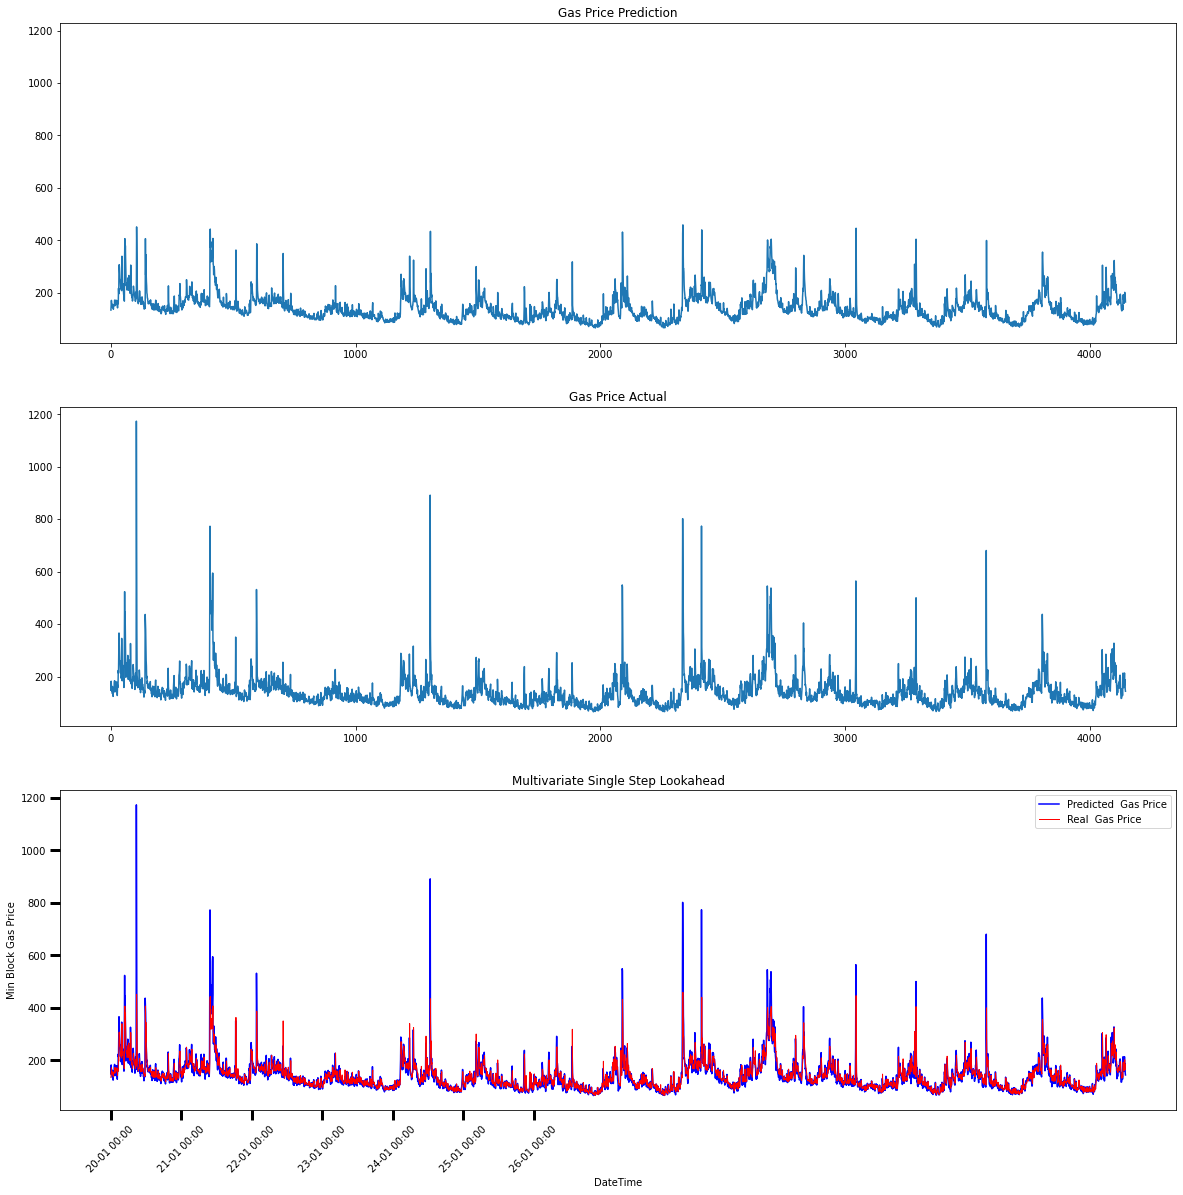

In [155]:
#Minmax scaler has been fit with nd data, 
pred_descaled= (scaler2.inverse_transform(array([yhat,]*len(inputs)).transpose()[0]))[ :, :1]
groud_truth_descaled= (scaler2.inverse_transform(array([y_val2,]*len(inputs)).transpose()[0][0]))[ :, :1]


f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)
f.set_figwidth(20)
f.set_figheight(20)
ax1.plot(pred_descaled)
ax1.title.set_text('Gas Price Prediction')
ax2.plot(groud_truth_descaled)
ax2.title.set_text('Gas Price Actual')


ax3.set_xticks(np.arange(0, 1985, 288, dtype=None))
ax3.set_xticklabels(data['datetime'].tail(7).values.tolist(), rotation = 45)
ax3.tick_params(length=10, width=3)
ax3.title.set_text('Multivariate Single Step Lookahead')
ax3.plot(groud_truth_descaled, color='blue',label='Predicted '+' Gas Price')
ax3.plot(pred_descaled, color='red',label='Real '+' Gas Price', linewidth=1)
ax3.legend(loc='upper right')
ax3.set_xlabel('DateTime')
ax3.set_ylabel('Min Block Gas Price')



print('RMSE ' + str(mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)))
print('MAE ' + str(mean_absolute_error(groud_truth_descaled, pred_descaled)))
print('MAPE ' + str(mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)))
print('R^2 ' + str(r2_score(groud_truth_descaled, pred_descaled)))

## Lets add contract count data

In [15]:
resample_rate = '5T'
start_date='2021-11-26 00:00:00'
end_date='2021-12-26 23:55:00' 
inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile', 'contracts']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 4032
n_steps_out = 1
#How many timesteps between start of training examples
step_interval = 1


X_train, y_train, X_val, y_val, scaler = training_split_no_limits(data)
X_train2, y_train2, X_val2, y_val2, scaler2 = training_split_no_limits(data)

In [28]:
model = Sequential()
model.add(LSTM(units =20,activation='tanh',input_shape=(n_steps_in, len(inputs)),dropout=0.01, return_sequences=True))
model.add(LSTM(units =20,activation='tanh',input_shape=(n_steps_in, len(inputs)),dropout=0.01, return_sequences=True))
model.add(LSTM(units =20,activation='tanh',input_shape=(n_steps_in, len(inputs)),dropout=0.01))
model.add(Dense(len(inputs)))
opt = keras.optimizers.Adam(learning_rate=0.01, decay=0.0001)
model.compile(optimizer='adam', loss='mse')



In [17]:
model.fit(X_train2, y_train2, epochs=15, verbose=1, validation_data=(X_val2, y_val2))

Epoch 1/15
108/108 [==============================] - 43s 343ms/step - loss: 0.3681 - val_loss: 0.0563
Epoch 2/15
108/108 [==============================] - 34s 313ms/step - loss: 0.3328 - val_loss: 0.0477
Epoch 3/15
108/108 [==============================] - 34s 313ms/step - loss: 0.3232 - val_loss: 0.0465
Epoch 4/15
108/108 [==============================] - 34s 315ms/step - loss: 0.3155 - val_loss: 0.0436
Epoch 5/15
108/108 [==============================] - 34s 315ms/step - loss: 0.3057 - val_loss: 0.0445
Epoch 6/15
108/108 [==============================] - 34s 314ms/step - loss: 0.2912 - val_loss: 0.0405
Epoch 7/15
108/108 [==============================] - 34s 318ms/step - loss: 0.2696 - val_loss: 0.0328
Epoch 8/15
108/108 [==============================] - 34s 316ms/step - loss: 0.2495 - val_loss: 0.0300
Epoch 9/15
108/108 [==============================] - 34s 314ms/step - loss: 0.2338 - val_loss: 0.0320
Epoch 10/15
108/108 [==============================] - 34s 315ms/step - l

In [18]:
yhat = model.predict(X_val2, verbose=1)

46/46 [==============================] - 8s 125ms/step


RMSE 12.190817304559003
MAE 7.878259622472101
MAPE 0.11058628785347785
R^2 0.740179245717715


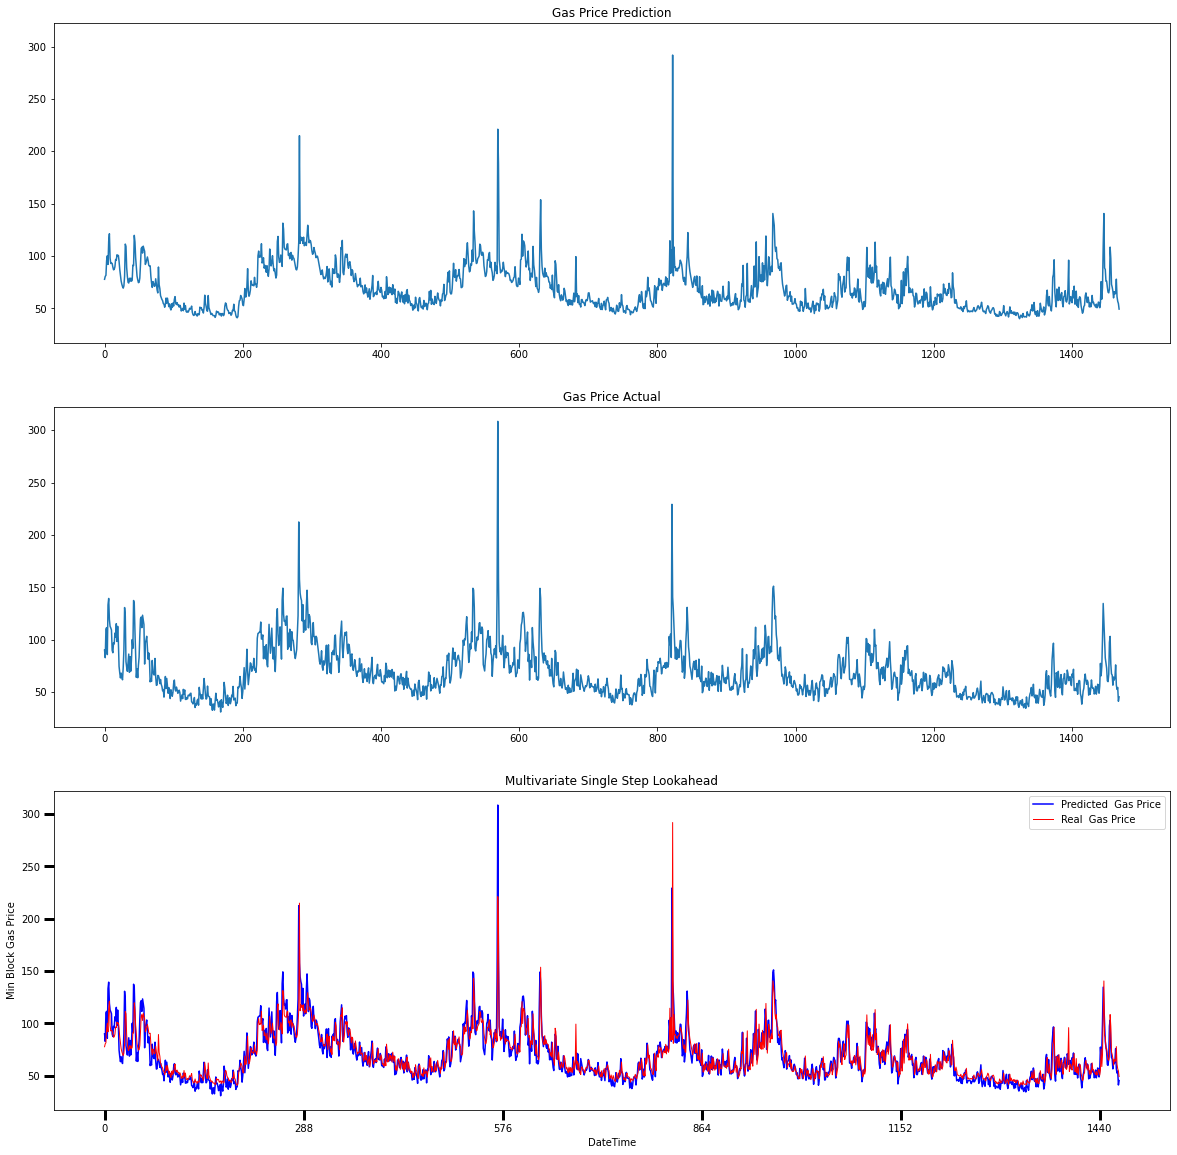

In [23]:
#Minmax scaler has been fit with nd data, 
pred_descaled= (scaler2.inverse_transform(array([yhat,]*len(inputs)).transpose()[0]))[ :, :1]
groud_truth_descaled= (scaler2.inverse_transform(array([y_val2,]*len(inputs)).transpose()[0][0]))[ :, :1]


f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)
f.set_figwidth(20)
f.set_figheight(20)
ax1.plot(pred_descaled)
ax1.title.set_text('Gas Price Prediction')
ax2.plot(groud_truth_descaled)
ax2.title.set_text('Gas Price Actual')


ax3.set_xticks(np.arange(0, 1985, 288, dtype=None))

ax3.tick_params(length=10, width=3)
ax3.title.set_text('Multivariate Single Step Lookahead')
ax3.plot(groud_truth_descaled, color='blue',label='Predicted '+' Gas Price')
ax3.plot(pred_descaled, color='red',label='Real '+' Gas Price', linewidth=1)
ax3.legend(loc='upper right')
ax3.set_xlabel('DateTime')
ax3.set_ylabel('Min Block Gas Price')



print('RMSE ' + str(mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)))
print('MAE ' + str(mean_absolute_error(groud_truth_descaled, pred_descaled)))
print('MAPE ' + str(mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)))
print('R^2 ' + str(r2_score(groud_truth_descaled, pred_descaled)))

# Training each month seperately, different variables

Let use the model with 3 layers and a 4032 step input. Metrics will be averaged acorss a seperate model for each of the 5 months of data.

## Lets get metrics for each month

In [29]:
# Min+Percentile
end_dates = ['2021-12-26 23:55:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00', '2022-04-26 23:55:00'  ]
Start_dates = ['2021-11-26 00:00:00', '2021-12-26 00:00:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00']
dict_indexes=[]
dict_dfs=[]
RMSE_list, MAE_list, MAPE_list, R2_list, MSE_list = [],[],[],[],[]
y_hat_list=[]
train_loss_list=[]
val_loss_list=[]
for i in [0, 1, 2, 3, 4]:
    resample_rate = '5T'
    start_date=Start_dates[i]
    end_date=end_dates[i] 
    inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile']
        #No of timesteps behind to forecast on, no of timesteps to forecast ahead
    n_steps_in = 4032
    n_steps_out = 1
        #How many timesteps between start of training examples
    step_interval = 1


    X_train, y_train, X_val, y_val, scaler = training_split_no_limits(data)
    X_train2, y_train2, X_val2, y_val2, scaler2 = training_split_no_limits(data)
        
        # define model
    model = Sequential()
    model.add(LSTM(units =15,activation='tanh',input_shape=(n_steps_in, len(inputs)),dropout=0.01))
    model.add(Dense(len(inputs)))
    opt = keras.optimizers.Adam(learning_rate=0.01, decay=0.0001)
    model.compile(optimizer='adam', loss='mse')
        
    train_history = model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=15, verbose=1)
    train_loss_list.append(train_history.history['loss'])
    val_loss_list.append(train_history.history['val_loss'])
    model.save(('Percentile tests/min+percentile'))
        
    
    yhat_val = model.predict(X_val, verbose=1)
    y_hat_list.append(yhat_val)
        
    RMSE, MAE, MAPE, R2, MSE = descale_y_retrun_metrics(yhat_val, y_val2)
    RMSE_list.append(RMSE)
    MAE_list.append(MAE)
    MAPE_list.append(MAPE)
    R2_list.append(R2)
    MSE_list.append(MSE)
    if i==4:
        pd.DataFrame(train_loss_list).to_csv('Percentile tests/min+percentile_train_loss')
        pd.DataFrame(val_loss_list).to_csv('Percentile tests/min+percentile_val_loss')
        metrics_df = pd.DataFrame({'RMSE':RMSE_list, 'MSE':MSE_list, 'MAE':MAE_list, 'MAPE':MAPE_list, 'R2':R2_list}, index=range(1,6))
        dict_dfs.append(metrics_df)
        dict_indexes.append(str(column))
                   
metrics_dict = dict(zip(dict_indexes, dict_dfs))
np.save("Percentile tests/min+percentile_metric_dict_1.npy", metrics_dict) 



Epoch 1/15
108/108 [==============================] - 20s 115ms/step - loss: 0.3856 - val_loss: 0.0429
Epoch 2/15
108/108 [==============================] - 11s 107ms/step - loss: 0.2996 - val_loss: 0.0381
Epoch 3/15
108/108 [==============================] - 11s 105ms/step - loss: 0.2849 - val_loss: 0.0348
Epoch 4/15
108/108 [==============================] - 11s 106ms/step - loss: 0.2707 - val_loss: 0.0324
Epoch 5/15
108/108 [==============================] - 12s 108ms/step - loss: 0.2574 - val_loss: 0.0310
Epoch 6/15
108/108 [==============================] - 11s 106ms/step - loss: 0.2460 - val_loss: 0.0282
Epoch 7/15
108/108 [==============================] - 11s 106ms/step - loss: 0.2407 - val_loss: 0.0273
Epoch 8/15
108/108 [==============================] - 11s 106ms/step - loss: 0.2342 - val_loss: 0.0287
Epoch 9/15
108/108 [==============================] - 11s 104ms/step - loss: 0.2297 - val_loss: 0.0272
Epoch 10/15
108/108 [==============================] - 12s 108ms/step - l

INFO:tensorflow:Assets written to: Percentile tests/min+percentile\assets


INFO:tensorflow:Assets written to: Percentile tests/min+percentile\assets


46/46 [==============================] - 3s 45ms/step
Epoch 1/15
114/114 [==============================] - 15s 112ms/step - loss: 1.0230 - val_loss: 0.3937
Epoch 2/15
114/114 [==============================] - 12s 106ms/step - loss: 0.4962 - val_loss: 0.2997
Epoch 3/15
114/114 [==============================] - 12s 107ms/step - loss: 0.4274 - val_loss: 0.2650
Epoch 4/15
114/114 [==============================] - 12s 107ms/step - loss: 0.3971 - val_loss: 0.2387
Epoch 5/15
114/114 [==============================] - 12s 107ms/step - loss: 0.3779 - val_loss: 0.2266
Epoch 6/15
114/114 [==============================] - 12s 107ms/step - loss: 0.3601 - val_loss: 0.2157
Epoch 7/15
114/114 [==============================] - 12s 108ms/step - loss: 0.3517 - val_loss: 0.2092
Epoch 8/15
114/114 [==============================] - 12s 106ms/step - loss: 0.3434 - val_loss: 0.2045
Epoch 9/15
114/114 [==============================] - 12s 107ms/step - loss: 0.3383 - val_loss: 0.2052
Epoch 10/15
114/114

INFO:tensorflow:Assets written to: Percentile tests/min+percentile\assets


INFO:tensorflow:Assets written to: Percentile tests/min+percentile\assets


49/49 [==============================] - 3s 40ms/step
Epoch 1/15
108/108 [==============================] - 15s 116ms/step - loss: 0.2322 - val_loss: 0.2719
Epoch 2/15
108/108 [==============================] - 11s 106ms/step - loss: 0.2047 - val_loss: 0.2554
Epoch 3/15
108/108 [==============================] - 11s 106ms/step - loss: 0.1981 - val_loss: 0.2437
Epoch 4/15
108/108 [==============================] - 12s 107ms/step - loss: 0.1934 - val_loss: 0.2354
Epoch 5/15
108/108 [==============================] - 11s 106ms/step - loss: 0.1900 - val_loss: 0.2285
Epoch 6/15
108/108 [==============================] - 12s 107ms/step - loss: 0.1873 - val_loss: 0.2235
Epoch 7/15
108/108 [==============================] - 11s 105ms/step - loss: 0.1852 - val_loss: 0.2209
Epoch 8/15
108/108 [==============================] - 11s 106ms/step - loss: 0.1828 - val_loss: 0.2192
Epoch 9/15
108/108 [==============================] - 12s 107ms/step - loss: 0.1809 - val_loss: 0.2161
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests/min+percentile\assets


INFO:tensorflow:Assets written to: Percentile tests/min+percentile\assets


46/46 [==============================] - 2s 41ms/step
Epoch 1/15
89/89 [==============================] - 13s 117ms/step - loss: 0.2927 - val_loss: 0.0304
Epoch 2/15
89/89 [==============================] - 10s 110ms/step - loss: 0.1692 - val_loss: 0.0246
Epoch 3/15
89/89 [==============================] - 10s 109ms/step - loss: 0.1625 - val_loss: 0.0236
Epoch 4/15
89/89 [==============================] - 10s 111ms/step - loss: 0.1582 - val_loss: 0.0228
Epoch 5/15
89/89 [==============================] - 10s 109ms/step - loss: 0.1547 - val_loss: 0.0219
Epoch 6/15
89/89 [==============================] - 10s 110ms/step - loss: 0.1506 - val_loss: 0.0216
Epoch 7/15
89/89 [==============================] - 10s 108ms/step - loss: 0.1471 - val_loss: 0.0213
Epoch 8/15
89/89 [==============================] - 9s 106ms/step - loss: 0.1441 - val_loss: 0.0213
Epoch 9/15
89/89 [==============================] - 9s 106ms/step - loss: 0.1415 - val_loss: 0.0217
Epoch 10/15
89/89 [====================

INFO:tensorflow:Assets written to: Percentile tests/min+percentile\assets


INFO:tensorflow:Assets written to: Percentile tests/min+percentile\assets


38/38 [==============================] - 2s 43ms/step
Epoch 1/15
108/108 [==============================] - 14s 111ms/step - loss: 0.2383 - val_loss: 0.0385
Epoch 2/15
108/108 [==============================] - 11s 106ms/step - loss: 0.1056 - val_loss: 0.0341
Epoch 3/15
108/108 [==============================] - 11s 106ms/step - loss: 0.0957 - val_loss: 0.0326
Epoch 4/15
108/108 [==============================] - 11s 106ms/step - loss: 0.0877 - val_loss: 0.0307
Epoch 5/15
108/108 [==============================] - 12s 107ms/step - loss: 0.0812 - val_loss: 0.0302
Epoch 6/15
108/108 [==============================] - 11s 106ms/step - loss: 0.0764 - val_loss: 0.0296
Epoch 7/15
108/108 [==============================] - 11s 105ms/step - loss: 0.0726 - val_loss: 0.0295
Epoch 8/15
108/108 [==============================] - 12s 107ms/step - loss: 0.0696 - val_loss: 0.0293
Epoch 9/15
108/108 [==============================] - 12s 108ms/step - loss: 0.0669 - val_loss: 0.0294
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests/min+percentile\assets


INFO:tensorflow:Assets written to: Percentile tests/min+percentile\assets


46/46 [==============================] - 3s 41ms/step


NameError: name 'column' is not defined

In [31]:
metrics_df

,RMSE,MSE,MAE,MAPE,R2
1,12.424997,154.380551,7.941618,0.108891,0.730101
2,32.362733,1047.346512,18.675755,0.123076,0.725272
3,33.642958,1131.848652,11.794134,0.145893,0.544367
4,10.652826,113.482710,6.798721,0.157231,0.713750
5,11.837748,140.132288,7.281291,0.175478,0.683590


In [32]:
metrics_df.mean()

RMSE     20.184253
MSE     517.438142
MAE      10.498304
MAPE      0.142114
R2        0.679416
dtype: float64

## Lets try each variable

In [34]:
column_list = usage_data.columns.drop('min_gas_price').tolist()

In [35]:
# Min+Percentile
end_dates = ['2021-12-26 23:55:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00', '2022-04-26 23:55:00'  ]
Start_dates = ['2021-11-26 00:00:00', '2021-12-26 00:00:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00']
dict_indexes=[]
dict_dfs=[]
RMSE_list, MAE_list, MAPE_list, R2_list, MSE_list = [],[],[],[],[]
y_hat_list=[]
train_loss_list=[]
val_loss_list=[]

for column in column_list:
    RMSE_list, MAE_list, MAPE_list, R2_list, MSE_list = [],[],[],[],[]
    y_hat_list=[]
    train_loss_list=[]
    val_loss_list=[]
    for i in [0, 1, 2, 3, 4]:
        resample_rate = '5T'
        start_date=Start_dates[i]
        end_date=end_dates[i] 
        inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile']
            #No of timesteps behind to forecast on, no of timesteps to forecast ahead
        n_steps_in = 4032
        n_steps_out = 1
            #How many timesteps between start of training examples
        step_interval = 1


        X_train, y_train, X_val, y_val, scaler = training_split_no_limits(data)
        X_train2, y_train2, X_val2, y_val2, scaler2 = training_split_no_limits(data)

            # define model
        model = Sequential()
        model.add(LSTM(units =15,activation='tanh',input_shape=(n_steps_in, len(inputs)),dropout=0.01))
        model.add(Dense(len(inputs)))
        opt = keras.optimizers.Adam(learning_rate=0.01, decay=0.0001)
        model.compile(optimizer='adam', loss='mse')

        train_history = model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=15, verbose=1)
        train_loss_list.append(train_history.history['loss'])
        val_loss_list.append(train_history.history['val_loss'])
        model.save(('Percentile tests/min+percentile'))


        yhat_val = model.predict(X_val, verbose=1)
        y_hat_list.append(yhat_val)

        RMSE, MAE, MAPE, R2, MSE = descale_y_retrun_metrics(yhat_val, y_val2)
        RMSE_list.append(RMSE)
        MAE_list.append(MAE)
        MAPE_list.append(MAPE)
        R2_list.append(R2)
        MSE_list.append(MSE)
        if i==4:
            pd.DataFrame(train_loss_list).to_csv('Percentile tests/min+percentile_train_loss')
            pd.DataFrame(val_loss_list).to_csv('Percentile tests/min+percentile_val_loss')
            metrics_df = pd.DataFrame({'RMSE':RMSE_list, 'MSE':MSE_list, 'MAE':MAE_list, 'MAPE':MAPE_list, 'R2':R2_list}, index=range(1,6))
            dict_dfs.append(metrics_df)
            dict_indexes.append(str(column))
                   
metrics_dict = dict(zip(dict_indexes, dict_dfs))
np.save("Percentile tests/metric_dict_1.npy", metrics_dict) 

Epoch 1/15
 17/108 [===>..........................] - ETA: 8s - loss: 0.4305

KeyboardInterrupt: 

In [17]:
metrics_dict.keys()

dict_keys(['gas_used', 'base_fee_per_gas', 'transaction_count', 'size', 'Open', 'avg_gas_price', 'max_gas_price'])

In [ ]:
mean_metrics=[]
for i in metrics_dict:
    mean_metrics.append(metrics_dict[i].mean())
    

In [ ]:
dict(zip(metrics_dict.keys(), mean_metrics))

{'gas_used': RMSE     19.178089
 MSE     476.614682
 MAE       9.552628
 MAPE      0.125000
 R2        0.714777
 dtype: float64,
 'base_fee_per_gas': RMSE     19.886506
 MSE     507.887695
 MAE      10.276278
 MAPE      0.132136
 R2        0.692624
 dtype: float64,
 'transaction_count': RMSE     19.998114
 MSE     513.994955
 MAE       9.937463
 MAPE      0.129076
 R2        0.687237
 dtype: float64,
 'size': RMSE     19.961092
 MSE     507.043576
 MAE      10.158176
 MAPE      0.132723
 R2        0.686908
 dtype: float64,
 'Open': RMSE     20.137202
 MSE     520.804306
 MAE      10.418755
 MAPE      0.135475
 R2        0.685102
 dtype: float64,
 'avg_gas_price': RMSE     20.110882
 MSE     515.475376
 MAE      10.463946
 MAPE      0.142116
 R2        0.682532
 dtype: float64,
 'max_gas_price': RMSE     20.419206
 MSE     531.317205
 MAE      10.752219
 MAPE      0.139929
 R2        0.674055
 dtype: float64}

In [8]:
#check to see if saved
np.load("Percentile tests/metric_dict_1.npy", allow_pickle=True)

array({'gas_used':         RMSE          MSE        MAE      MAPE        R2
1  12.807365   164.028611   7.835951  0.109367  0.713234
2  30.283791   917.107984  17.128369  0.112877  0.759435
3  33.339971  1111.553698  11.124214  0.136127  0.552537
4   9.004884    81.087927   5.742576  0.135269  0.795463
5  10.454434   109.295192   5.932032  0.131360  0.753218, 'base_fee_per_gas':         RMSE          MSE        MAE      MAPE        R2
1  12.233211   149.651442   7.991457  0.111494  0.738369
2  32.176202  1035.307953  18.976157  0.126575  0.728430
3  33.503586  1122.490252  11.717912  0.142086  0.548134
4  10.288747   105.858307   6.395652  0.144501  0.732982
5  11.230785   126.130523   6.300209  0.136027  0.715205, 'transaction_count':         RMSE          MSE        MAE      MAPE        R2
1  11.680202   136.427111   7.532200  0.104032  0.761489
2  31.962398  1021.594866  17.684957  0.114192  0.732027
3  34.129878  1164.848568  11.436363  0.135920  0.531083
4  10.733251   115.202688 

### Run again for contract data, loop was cut off early

In [31]:
end_dates = ['2021-12-26 23:55:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00', '2022-04-26 23:55:00'  ]
Start_dates = ['2021-11-26 00:00:00', '2021-12-26 00:00:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00']
dict_indexes=[]
dict_dfs=[]
column = 'contracts'
RMSE_list, MAE_list, MAPE_list, R2_list, MSE_list = [],[],[],[],[]
y_hat_list=[]
train_loss_list=[]
val_loss_list=[]
for i in [0, 1, 2, 3, 4]:
        resample_rate = '5T'
        start_date=Start_dates[i]
        end_date=end_dates[i] 
        inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile']
        #No of timesteps behind to forecast on, no of timesteps to forecast ahead
        n_steps_in = 4032
        n_steps_out = 1
        #How many timesteps between start of training examples
        step_interval = 1


        X_train, y_train, X_val, y_val, scaler = training_split_no_limits(data)
        X_train2, y_train2, X_val2, y_val2, scaler2 = training_split_no_limits(data)
        
        # define model
        model = Sequential()
        model.add(LSTM(units =15,activation='tanh',input_shape=(n_steps_in, len(inputs)),dropout=0.01))
        model.add(Dense(len(inputs)))
        opt = keras.optimizers.Adam(learning_rate=0.01, decay=0.0001)
        model.compile(optimizer='adam', loss='mse')
        
        train_history = model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=15, verbose=1)
        train_loss_list.append(train_history.history['loss'])
        val_loss_list.append(train_history.history['val_loss'])
        model.save(('Percentile tests/'+str(column)+str([i])))
        
    
        yhat_val = model.predict(X_val, verbose=1)
        y_hat_list.append(yhat_val)
        
        RMSE, MAE, MAPE, R2, MSE = descale_y_retrun_metrics(yhat_val, y_val2)
        RMSE_list.append(RMSE)
        MAE_list.append(MAE)
        MAPE_list.append(MAPE)
        R2_list.append(R2)
        MSE_list.append(MSE)
        if i==4:
            pd.DataFrame(train_loss_list).to_csv('Percentile tests/' +str(column) +'train_loss')
            pd.DataFrame(val_loss_list).to_csv('Percentile tests/' +str(column) +'val_loss')
            metrics_df = pd.DataFrame({'RMSE':RMSE_list, 'MSE':MSE_list, 'MAE':MAE_list, 'MAPE':MAPE_list, 'R2':R2_list}, index=range(1,6))
            dict_dfs.append(metrics_df)
            dict_indexes.append(str(column))
                   
            
      
        

        
    

Epoch 1/15
108/108 [==============================] - 15s 115ms/step - loss: 0.3664 - val_loss: 0.0419
Epoch 2/15
108/108 [==============================] - 12s 107ms/step - loss: 0.2997 - val_loss: 0.0386
Epoch 3/15
108/108 [==============================] - 12s 108ms/step - loss: 0.2818 - val_loss: 0.0352
Epoch 4/15
108/108 [==============================] - 12s 108ms/step - loss: 0.2694 - val_loss: 0.0352
Epoch 5/15
108/108 [==============================] - 12s 108ms/step - loss: 0.2568 - val_loss: 0.0317
Epoch 6/15
108/108 [==============================] - 12s 111ms/step - loss: 0.2492 - val_loss: 0.0306
Epoch 7/15
108/108 [==============================] - 11s 107ms/step - loss: 0.2396 - val_loss: 0.0304
Epoch 8/15
108/108 [==============================] - 11s 102ms/step - loss: 0.2326 - val_loss: 0.0295
Epoch 9/15
108/108 [==============================] - 11s 101ms/step - loss: 0.2263 - val_loss: 0.0303
Epoch 10/15
108/108 [==============================] - 11s 101ms/step - l

INFO:tensorflow:Assets written to: Percentile tests/contracts[0]\assets


INFO:tensorflow:Assets written to: Percentile tests/contracts[0]\assets


46/46 [==============================] - 3s 44ms/step
Epoch 1/15
114/114 [==============================] - 15s 111ms/step - loss: 1.0279 - val_loss: 0.3919
Epoch 2/15
114/114 [==============================] - 12s 106ms/step - loss: 0.5061 - val_loss: 0.3136
Epoch 3/15
114/114 [==============================] - 12s 105ms/step - loss: 0.4454 - val_loss: 0.2720
Epoch 4/15
114/114 [==============================] - 13s 110ms/step - loss: 0.4106 - val_loss: 0.2463
Epoch 5/15
114/114 [==============================] - 12s 107ms/step - loss: 0.3813 - val_loss: 0.2291
Epoch 6/15
114/114 [==============================] - 12s 108ms/step - loss: 0.3643 - val_loss: 0.2191
Epoch 7/15
114/114 [==============================] - 12s 106ms/step - loss: 0.3490 - val_loss: 0.2100
Epoch 8/15
114/114 [==============================] - 12s 104ms/step - loss: 0.3429 - val_loss: 0.2055
Epoch 9/15
114/114 [==============================] - 12s 104ms/step - loss: 0.3323 - val_loss: 0.2011
Epoch 10/15
114/114

INFO:tensorflow:Assets written to: Percentile tests/contracts[1]\assets


INFO:tensorflow:Assets written to: Percentile tests/contracts[1]\assets


49/49 [==============================] - 3s 41ms/step
Epoch 1/15
108/108 [==============================] - 14s 110ms/step - loss: 0.2492 - val_loss: 0.2864
Epoch 2/15
108/108 [==============================] - 11s 104ms/step - loss: 0.2104 - val_loss: 0.2608
Epoch 3/15
108/108 [==============================] - 11s 103ms/step - loss: 0.2018 - val_loss: 0.2468
Epoch 4/15
108/108 [==============================] - 11s 103ms/step - loss: 0.1966 - val_loss: 0.2376
Epoch 5/15
108/108 [==============================] - 11s 103ms/step - loss: 0.1940 - val_loss: 0.2313
Epoch 6/15
108/108 [==============================] - 11s 101ms/step - loss: 0.1905 - val_loss: 0.2278
Epoch 7/15
108/108 [==============================] - 11s 106ms/step - loss: 0.1886 - val_loss: 0.2222
Epoch 8/15
108/108 [==============================] - 11s 105ms/step - loss: 0.1861 - val_loss: 0.2189
Epoch 9/15
108/108 [==============================] - 11s 106ms/step - loss: 0.1847 - val_loss: 0.2164
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests/contracts[2]\assets


INFO:tensorflow:Assets written to: Percentile tests/contracts[2]\assets


46/46 [==============================] - 2s 38ms/step
Epoch 1/15
89/89 [==============================] - 12s 109ms/step - loss: 0.2257 - val_loss: 0.0288
Epoch 2/15
89/89 [==============================] - 9s 102ms/step - loss: 0.1625 - val_loss: 0.0255
Epoch 3/15
89/89 [==============================] - 10s 110ms/step - loss: 0.1569 - val_loss: 0.0233
Epoch 4/15
89/89 [==============================] - 10s 117ms/step - loss: 0.1530 - val_loss: 0.0226
Epoch 5/15
89/89 [==============================] - 10s 111ms/step - loss: 0.1495 - val_loss: 0.0221
Epoch 6/15
89/89 [==============================] - 9s 106ms/step - loss: 0.1467 - val_loss: 0.0218
Epoch 7/15
89/89 [==============================] - 10s 110ms/step - loss: 0.1434 - val_loss: 0.0213
Epoch 8/15
89/89 [==============================] - 9s 106ms/step - loss: 0.1415 - val_loss: 0.0210
Epoch 9/15
89/89 [==============================] - 9s 106ms/step - loss: 0.1393 - val_loss: 0.0206
Epoch 10/15
89/89 [======================

INFO:tensorflow:Assets written to: Percentile tests/contracts[3]\assets


INFO:tensorflow:Assets written to: Percentile tests/contracts[3]\assets


38/38 [==============================] - 2s 41ms/step
Epoch 1/15
108/108 [==============================] - 15s 110ms/step - loss: 0.1467 - val_loss: 0.0321
Epoch 2/15
108/108 [==============================] - 11s 104ms/step - loss: 0.0949 - val_loss: 0.0300
Epoch 3/15
108/108 [==============================] - 12s 107ms/step - loss: 0.0848 - val_loss: 0.0290
Epoch 4/15
108/108 [==============================] - 11s 104ms/step - loss: 0.0785 - val_loss: 0.0276
Epoch 5/15
108/108 [==============================] - 11s 104ms/step - loss: 0.0734 - val_loss: 0.0270
Epoch 6/15
108/108 [==============================] - 11s 105ms/step - loss: 0.0695 - val_loss: 0.0262
Epoch 7/15
108/108 [==============================] - 11s 105ms/step - loss: 0.0664 - val_loss: 0.0261
Epoch 8/15
108/108 [==============================] - 11s 105ms/step - loss: 0.0636 - val_loss: 0.0258
Epoch 9/15
108/108 [==============================] - 11s 105ms/step - loss: 0.0613 - val_loss: 0.0261
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests/contracts[4]\assets


INFO:tensorflow:Assets written to: Percentile tests/contracts[4]\assets


46/46 [==============================] - 3s 40ms/step


In [34]:
metrics_df.mean()

RMSE     20.089744
MSE     513.703739
MAE      10.401495
MAPE      0.135485
R2        0.683960
dtype: float64

## Lets try additional percentiles 

In [52]:
column_list = percentile_data.columns.drop('block_gas_5th_percentile', 'block_gas_95th_percentile').tolist()

In [55]:
end_dates = ['2021-12-26 23:55:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00', '2022-04-26 23:55:00'  ]
Start_dates = ['2021-11-26 00:00:00', '2021-12-26 00:00:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00']
dict_indexes=[]
dict_dfs=[]

for column in column_list:
    RMSE_list, MAE_list, MAPE_list, R2_list, MSE_list = [],[],[],[],[]
    y_hat_list=[]
    train_loss_list=[]
    val_loss_list=[]
    for i in [0, 1, 2, 3, 4]:
        resample_rate = '5T'
        start_date=Start_dates[i]
        end_date=end_dates[i] 
        inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile', str(column)]
        #No of timesteps behind to forecast on, no of timesteps to forecast ahead
        n_steps_in = 4032
        n_steps_out = 1
        #How many timesteps between start of training examples
        step_interval = 1


        X_train, y_train, X_val, y_val, scaler = training_split_no_limits(data)
        X_train2, y_train2, X_val2, y_val2, scaler2 = training_split_no_limits(data)
        
        # define model
        model = Sequential()
        model.add(LSTM(units =15,activation='tanh',input_shape=(n_steps_in, len(inputs)),dropout=0.01))
        model.add(Dense(len(inputs)))
        opt = keras.optimizers.Adam(learning_rate=0.01, decay=0.0001)
        model.compile(optimizer='adam', loss='mse')
        
        train_history = model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=15, verbose=1)
        train_loss_list.append(train_history.history['loss'])
        val_loss_list.append(train_history.history['val_loss'])
        model.save(('Percentile tests_2/'+str(column)+str([i])))
        
    
        yhat_val = model.predict(X_val, verbose=1)
        y_hat_list.append(yhat_val)
        
        RMSE, MAE, MAPE, R2, MSE = descale_y_retrun_metrics(yhat_val, y_val2)
        RMSE_list.append(RMSE)
        MAE_list.append(MAE)
        MAPE_list.append(MAPE)
        R2_list.append(R2)
        MSE_list.append(MSE)
        if i==4:
            pd.DataFrame(train_loss_list).to_csv('Percentile tests_2/' +str(column) +'train_loss')
            pd.DataFrame(val_loss_list).to_csv('Percentile tests_2/' +str(column) +'val_loss')
            metrics_df = pd.DataFrame({'RMSE':RMSE_list, 'MSE':MSE_list, 'MAE':MAE_list, 'MAPE':MAPE_list, 'R2':R2_list}, index=range(1,6))
            dict_dfs.append(metrics_df)
            dict_indexes.append(str(column))
                   
metrics_dict_2 = dict(zip(dict_indexes, dict_dfs))
np.save("Percentile tests_2/metric_dict_1.npy", metrics_dict_2)  

Epoch 1/15
108/108 [==============================] - 16s 116ms/step - loss: 0.3611 - val_loss: 0.0404
Epoch 2/15
108/108 [==============================] - 12s 109ms/step - loss: 0.2989 - val_loss: 0.0355
Epoch 3/15
108/108 [==============================] - 12s 108ms/step - loss: 0.2768 - val_loss: 0.0336
Epoch 4/15
108/108 [==============================] - 12s 108ms/step - loss: 0.2625 - val_loss: 0.0316
Epoch 5/15
108/108 [==============================] - 12s 107ms/step - loss: 0.2501 - val_loss: 0.0304
Epoch 6/15
108/108 [==============================] - 12s 108ms/step - loss: 0.2407 - val_loss: 0.0291
Epoch 7/15
108/108 [==============================] - 12s 108ms/step - loss: 0.2337 - val_loss: 0.0279
Epoch 8/15
108/108 [==============================] - 12s 108ms/step - loss: 0.2277 - val_loss: 0.0313
Epoch 9/15
108/108 [==============================] - 12s 107ms/step - loss: 0.2223 - val_loss: 0.0295
Epoch 10/15
108/108 [==============================] - 12s 107ms/step - l

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_0th_percentile[0]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_0th_percentile[0]\assets


46/46 [==============================] - 3s 44ms/step
Epoch 1/15
114/114 [==============================] - 15s 113ms/step - loss: 1.0066 - val_loss: 0.3718
Epoch 2/15
114/114 [==============================] - 12s 107ms/step - loss: 0.4859 - val_loss: 0.2999
Epoch 3/15
114/114 [==============================] - 12s 108ms/step - loss: 0.4288 - val_loss: 0.2600
Epoch 4/15
114/114 [==============================] - 12s 106ms/step - loss: 0.3988 - val_loss: 0.2389
Epoch 5/15
114/114 [==============================] - 12s 107ms/step - loss: 0.3811 - val_loss: 0.2276
Epoch 6/15
114/114 [==============================] - 12s 109ms/step - loss: 0.3626 - val_loss: 0.2187
Epoch 7/15
114/114 [==============================] - 12s 107ms/step - loss: 0.3503 - val_loss: 0.2074
Epoch 8/15
114/114 [==============================] - 12s 107ms/step - loss: 0.3486 - val_loss: 0.2029
Epoch 9/15
114/114 [==============================] - 12s 107ms/step - loss: 0.3391 - val_loss: 0.1990
Epoch 10/15
114/114

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_0th_percentile[1]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_0th_percentile[1]\assets


49/49 [==============================] - 3s 44ms/step
Epoch 1/15
108/108 [==============================] - 15s 113ms/step - loss: 0.3384 - val_loss: 0.3263
Epoch 2/15
108/108 [==============================] - 12s 108ms/step - loss: 0.2225 - val_loss: 0.2700
Epoch 3/15
108/108 [==============================] - 12s 107ms/step - loss: 0.2047 - val_loss: 0.2513
Epoch 4/15
108/108 [==============================] - 12s 108ms/step - loss: 0.1974 - val_loss: 0.2396
Epoch 5/15
108/108 [==============================] - 12s 108ms/step - loss: 0.1932 - val_loss: 0.2313
Epoch 6/15
108/108 [==============================] - 11s 106ms/step - loss: 0.1897 - val_loss: 0.2248
Epoch 7/15
108/108 [==============================] - 12s 107ms/step - loss: 0.1867 - val_loss: 0.2201
Epoch 8/15
108/108 [==============================] - 12s 107ms/step - loss: 0.1843 - val_loss: 0.2161
Epoch 9/15
108/108 [==============================] - 12s 108ms/step - loss: 0.1838 - val_loss: 0.2150
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_0th_percentile[2]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_0th_percentile[2]\assets


46/46 [==============================] - 3s 44ms/step
Epoch 1/15
89/89 [==============================] - 12s 115ms/step - loss: 0.2657 - val_loss: 0.0344
Epoch 2/15
89/89 [==============================] - 10s 108ms/step - loss: 0.1700 - val_loss: 0.0272
Epoch 3/15
89/89 [==============================] - 10s 108ms/step - loss: 0.1612 - val_loss: 0.0245
Epoch 4/15
89/89 [==============================] - 10s 108ms/step - loss: 0.1551 - val_loss: 0.0237
Epoch 5/15
89/89 [==============================] - 10s 108ms/step - loss: 0.1495 - val_loss: 0.0226
Epoch 6/15
89/89 [==============================] - 10s 108ms/step - loss: 0.1459 - val_loss: 0.0216
Epoch 7/15
89/89 [==============================] - 10s 108ms/step - loss: 0.1430 - val_loss: 0.0210
Epoch 8/15
89/89 [==============================] - 10s 107ms/step - loss: 0.1403 - val_loss: 0.0210
Epoch 9/15
89/89 [==============================] - 10s 108ms/step - loss: 0.1386 - val_loss: 0.0211
Epoch 10/15
89/89 [==================

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_0th_percentile[3]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_0th_percentile[3]\assets


38/38 [==============================] - 2s 46ms/step
Epoch 1/15
108/108 [==============================] - 16s 117ms/step - loss: 0.1242 - val_loss: 0.0294
Epoch 2/15
108/108 [==============================] - 12s 107ms/step - loss: 0.0933 - val_loss: 0.0282
Epoch 3/15
108/108 [==============================] - 11s 105ms/step - loss: 0.0843 - val_loss: 0.0278
Epoch 4/15
108/108 [==============================] - 11s 106ms/step - loss: 0.0757 - val_loss: 0.0275
Epoch 5/15
108/108 [==============================] - 12s 113ms/step - loss: 0.0697 - val_loss: 0.0270
Epoch 6/15
108/108 [==============================] - 12s 111ms/step - loss: 0.0653 - val_loss: 0.0262
Epoch 7/15
108/108 [==============================] - 12s 110ms/step - loss: 0.0629 - val_loss: 0.0259
Epoch 8/15
108/108 [==============================] - 12s 111ms/step - loss: 0.0603 - val_loss: 0.0270
Epoch 9/15
108/108 [==============================] - 12s 112ms/step - loss: 0.0590 - val_loss: 0.0255
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_0th_percentile[4]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_0th_percentile[4]\assets


46/46 [==============================] - 3s 48ms/step
Epoch 1/15
108/108 [==============================] - 15s 120ms/step - loss: 0.3399 - val_loss: 0.0391
Epoch 2/15
108/108 [==============================] - 12s 113ms/step - loss: 0.2870 - val_loss: 0.0348
Epoch 3/15
108/108 [==============================] - 12s 114ms/step - loss: 0.2695 - val_loss: 0.0327
Epoch 4/15
108/108 [==============================] - 12s 111ms/step - loss: 0.2584 - val_loss: 0.0308
Epoch 5/15
108/108 [==============================] - 12s 116ms/step - loss: 0.2480 - val_loss: 0.0306
Epoch 6/15
108/108 [==============================] - 12s 114ms/step - loss: 0.2392 - val_loss: 0.0273
Epoch 7/15
108/108 [==============================] - 12s 116ms/step - loss: 0.2324 - val_loss: 0.0273
Epoch 8/15
108/108 [==============================] - 12s 113ms/step - loss: 0.2243 - val_loss: 0.0301
Epoch 9/15
108/108 [==============================] - 12s 113ms/step - loss: 0.2213 - val_loss: 0.0264
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_10th_percentile[0]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_10th_percentile[0]\assets


46/46 [==============================] - 3s 45ms/step
Epoch 1/15
114/114 [==============================] - 16s 116ms/step - loss: 0.8270 - val_loss: 0.3349
Epoch 2/15
114/114 [==============================] - 12s 109ms/step - loss: 0.4537 - val_loss: 0.2765
Epoch 3/15
114/114 [==============================] - 12s 110ms/step - loss: 0.4047 - val_loss: 0.2483
Epoch 4/15
114/114 [==============================] - 12s 110ms/step - loss: 0.3800 - val_loss: 0.2320
Epoch 5/15
114/114 [==============================] - 13s 111ms/step - loss: 0.3658 - val_loss: 0.2173
Epoch 6/15
114/114 [==============================] - 12s 109ms/step - loss: 0.3509 - val_loss: 0.2089
Epoch 7/15
114/114 [==============================] - 13s 110ms/step - loss: 0.3415 - val_loss: 0.2035
Epoch 8/15
114/114 [==============================] - 13s 110ms/step - loss: 0.3341 - val_loss: 0.1987
Epoch 9/15
114/114 [==============================] - 13s 111ms/step - loss: 0.3334 - val_loss: 0.1981
Epoch 10/15
114/114

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_10th_percentile[1]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_10th_percentile[1]\assets


49/49 [==============================] - 3s 45ms/step
Epoch 1/15
108/108 [==============================] - 14s 112ms/step - loss: 0.2581 - val_loss: 0.2824
Epoch 2/15
108/108 [==============================] - 11s 105ms/step - loss: 0.2107 - val_loss: 0.2551
Epoch 3/15
108/108 [==============================] - 11s 106ms/step - loss: 0.2010 - val_loss: 0.2438
Epoch 4/15
108/108 [==============================] - 13s 119ms/step - loss: 0.1955 - val_loss: 0.2343
Epoch 5/15
108/108 [==============================] - 12s 114ms/step - loss: 0.1919 - val_loss: 0.2283
Epoch 6/15
108/108 [==============================] - 12s 113ms/step - loss: 0.1914 - val_loss: 0.2235
Epoch 7/15
108/108 [==============================] - 12s 112ms/step - loss: 0.1876 - val_loss: 0.2193
Epoch 8/15
108/108 [==============================] - 12s 112ms/step - loss: 0.1843 - val_loss: 0.2167
Epoch 9/15
108/108 [==============================] - 11s 106ms/step - loss: 0.1845 - val_loss: 0.2154
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_10th_percentile[2]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_10th_percentile[2]\assets


46/46 [==============================] - 3s 43ms/step
Epoch 1/15
89/89 [==============================] - 12s 113ms/step - loss: 0.2403 - val_loss: 0.0254
Epoch 2/15
89/89 [==============================] - 10s 109ms/step - loss: 0.1592 - val_loss: 0.0231
Epoch 3/15
89/89 [==============================] - 10s 107ms/step - loss: 0.1516 - val_loss: 0.0221
Epoch 4/15
89/89 [==============================] - 10s 108ms/step - loss: 0.1457 - val_loss: 0.0212
Epoch 5/15
89/89 [==============================] - 10s 108ms/step - loss: 0.1413 - val_loss: 0.0205
Epoch 6/15
89/89 [==============================] - 9s 107ms/step - loss: 0.1378 - val_loss: 0.0204
Epoch 7/15
89/89 [==============================] - 10s 108ms/step - loss: 0.1345 - val_loss: 0.0205
Epoch 8/15
89/89 [==============================] - 10s 107ms/step - loss: 0.1323 - val_loss: 0.0203
Epoch 9/15
89/89 [==============================] - 9s 107ms/step - loss: 0.1313 - val_loss: 0.0217
Epoch 10/15
89/89 [====================

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_10th_percentile[3]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_10th_percentile[3]\assets


38/38 [==============================] - 2s 50ms/step
Epoch 1/15
108/108 [==============================] - 15s 117ms/step - loss: 0.1633 - val_loss: 0.0330
Epoch 2/15
108/108 [==============================] - 12s 112ms/step - loss: 0.0981 - val_loss: 0.0303
Epoch 3/15
108/108 [==============================] - 12s 110ms/step - loss: 0.0879 - val_loss: 0.0286
Epoch 4/15
108/108 [==============================] - 12s 110ms/step - loss: 0.0802 - val_loss: 0.0277
Epoch 5/15
108/108 [==============================] - 12s 110ms/step - loss: 0.0739 - val_loss: 0.0274
Epoch 6/15
108/108 [==============================] - 12s 111ms/step - loss: 0.0692 - val_loss: 0.0262
Epoch 7/15
108/108 [==============================] - 12s 109ms/step - loss: 0.0656 - val_loss: 0.0255
Epoch 8/15
108/108 [==============================] - 12s 113ms/step - loss: 0.0634 - val_loss: 0.0249
Epoch 9/15
108/108 [==============================] - 12s 112ms/step - loss: 0.0608 - val_loss: 0.0254
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_10th_percentile[4]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_10th_percentile[4]\assets


46/46 [==============================] - 3s 48ms/step
Epoch 1/15
108/108 [==============================] - 15s 117ms/step - loss: 0.4441 - val_loss: 0.0463
Epoch 2/15
108/108 [==============================] - 12s 109ms/step - loss: 0.3117 - val_loss: 0.0389
Epoch 3/15
108/108 [==============================] - 11s 107ms/step - loss: 0.2846 - val_loss: 0.0388
Epoch 4/15
108/108 [==============================] - 12s 107ms/step - loss: 0.2676 - val_loss: 0.0344
Epoch 5/15
108/108 [==============================] - 12s 109ms/step - loss: 0.2550 - val_loss: 0.0311
Epoch 6/15
108/108 [==============================] - 12s 107ms/step - loss: 0.2442 - val_loss: 0.0292
Epoch 7/15
108/108 [==============================] - 11s 107ms/step - loss: 0.2346 - val_loss: 0.0288
Epoch 8/15
108/108 [==============================] - 12s 113ms/step - loss: 0.2314 - val_loss: 0.0283
Epoch 9/15
108/108 [==============================] - 12s 110ms/step - loss: 0.2226 - val_loss: 0.0287
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_20th_percentile[0]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_20th_percentile[0]\assets


46/46 [==============================] - 3s 46ms/step
Epoch 1/15
114/114 [==============================] - 16s 115ms/step - loss: 0.7322 - val_loss: 0.3018
Epoch 2/15
114/114 [==============================] - 12s 107ms/step - loss: 0.4238 - val_loss: 0.2578
Epoch 3/15
114/114 [==============================] - 12s 109ms/step - loss: 0.3934 - val_loss: 0.2334
Epoch 4/15
114/114 [==============================] - 12s 108ms/step - loss: 0.3689 - val_loss: 0.2250
Epoch 5/15
114/114 [==============================] - 12s 108ms/step - loss: 0.3547 - val_loss: 0.2119
Epoch 6/15
114/114 [==============================] - 12s 109ms/step - loss: 0.3435 - val_loss: 0.2109
Epoch 7/15
114/114 [==============================] - 13s 111ms/step - loss: 0.3421 - val_loss: 0.2007
Epoch 8/15
114/114 [==============================] - 13s 111ms/step - loss: 0.3343 - val_loss: 0.1981
Epoch 9/15
114/114 [==============================] - 13s 113ms/step - loss: 0.3288 - val_loss: 0.1951
Epoch 10/15
114/114

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_20th_percentile[1]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_20th_percentile[1]\assets


49/49 [==============================] - 3s 47ms/step
Epoch 1/15
108/108 [==============================] - 15s 117ms/step - loss: 0.2917 - val_loss: 0.3088
Epoch 2/15
108/108 [==============================] - 12s 113ms/step - loss: 0.2188 - val_loss: 0.2717
Epoch 3/15
108/108 [==============================] - 12s 110ms/step - loss: 0.2059 - val_loss: 0.2527
Epoch 4/15
108/108 [==============================] - 12s 109ms/step - loss: 0.1982 - val_loss: 0.2416
Epoch 5/15
108/108 [==============================] - 12s 109ms/step - loss: 0.1948 - val_loss: 0.2327
Epoch 6/15
108/108 [==============================] - 12s 110ms/step - loss: 0.1909 - val_loss: 0.2247
Epoch 7/15
108/108 [==============================] - 12s 110ms/step - loss: 0.1881 - val_loss: 0.2217
Epoch 8/15
108/108 [==============================] - 12s 109ms/step - loss: 0.1859 - val_loss: 0.2187
Epoch 9/15
108/108 [==============================] - 12s 112ms/step - loss: 0.1834 - val_loss: 0.2143
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_20th_percentile[2]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_20th_percentile[2]\assets


46/46 [==============================] - 3s 45ms/step
Epoch 1/15
89/89 [==============================] - 13s 119ms/step - loss: 0.2917 - val_loss: 0.0322
Epoch 2/15
89/89 [==============================] - 10s 109ms/step - loss: 0.1707 - val_loss: 0.0248
Epoch 3/15
89/89 [==============================] - 10s 108ms/step - loss: 0.1620 - val_loss: 0.0233
Epoch 4/15
89/89 [==============================] - 10s 108ms/step - loss: 0.1566 - val_loss: 0.0228
Epoch 5/15
89/89 [==============================] - 10s 108ms/step - loss: 0.1517 - val_loss: 0.0220
Epoch 6/15
89/89 [==============================] - 10s 110ms/step - loss: 0.1475 - val_loss: 0.0215
Epoch 7/15
89/89 [==============================] - 10s 110ms/step - loss: 0.1443 - val_loss: 0.0211
Epoch 8/15
89/89 [==============================] - 9s 107ms/step - loss: 0.1409 - val_loss: 0.0212
Epoch 9/15
89/89 [==============================] - 10s 113ms/step - loss: 0.1392 - val_loss: 0.0211
Epoch 10/15
89/89 [===================

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_20th_percentile[3]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_20th_percentile[3]\assets


38/38 [==============================] - 2s 46ms/step
Epoch 1/15
108/108 [==============================] - 15s 115ms/step - loss: 0.1424 - val_loss: 0.0307
Epoch 2/15
108/108 [==============================] - 12s 110ms/step - loss: 0.0866 - val_loss: 0.0285
Epoch 3/15
108/108 [==============================] - 12s 109ms/step - loss: 0.0778 - val_loss: 0.0282
Epoch 4/15
108/108 [==============================] - 12s 111ms/step - loss: 0.0714 - val_loss: 0.0272
Epoch 5/15
108/108 [==============================] - 12s 110ms/step - loss: 0.0670 - val_loss: 0.0259
Epoch 6/15
108/108 [==============================] - 12s 111ms/step - loss: 0.0638 - val_loss: 0.0252
Epoch 7/15
108/108 [==============================] - 12s 108ms/step - loss: 0.0613 - val_loss: 0.0245
Epoch 8/15
108/108 [==============================] - 12s 108ms/step - loss: 0.0592 - val_loss: 0.0239
Epoch 9/15
108/108 [==============================] - 11s 106ms/step - loss: 0.0575 - val_loss: 0.0239
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_20th_percentile[4]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_20th_percentile[4]\assets


46/46 [==============================] - 3s 45ms/step
Epoch 1/15
108/108 [==============================] - 15s 117ms/step - loss: 0.3490 - val_loss: 0.0404
Epoch 2/15
108/108 [==============================] - 12s 108ms/step - loss: 0.2865 - val_loss: 0.0363
Epoch 3/15
108/108 [==============================] - 12s 109ms/step - loss: 0.2678 - val_loss: 0.0332
Epoch 4/15
108/108 [==============================] - 12s 109ms/step - loss: 0.2554 - val_loss: 0.0324
Epoch 5/15
108/108 [==============================] - 12s 109ms/step - loss: 0.2444 - val_loss: 0.0303
Epoch 6/15
108/108 [==============================] - 11s 107ms/step - loss: 0.2387 - val_loss: 0.0289
Epoch 7/15
108/108 [==============================] - 12s 108ms/step - loss: 0.2313 - val_loss: 0.0295
Epoch 8/15
108/108 [==============================] - 11s 106ms/step - loss: 0.2278 - val_loss: 0.0287
Epoch 9/15
108/108 [==============================] - 12s 107ms/step - loss: 0.2209 - val_loss: 0.0309
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_30th_percentile[0]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_30th_percentile[0]\assets


46/46 [==============================] - 3s 44ms/step
Epoch 1/15
114/114 [==============================] - 16s 117ms/step - loss: 1.0094 - val_loss: 0.3801
Epoch 2/15
114/114 [==============================] - 12s 109ms/step - loss: 0.4907 - val_loss: 0.3011
Epoch 3/15
114/114 [==============================] - 12s 108ms/step - loss: 0.4316 - val_loss: 0.2712
Epoch 4/15
114/114 [==============================] - 12s 105ms/step - loss: 0.3942 - val_loss: 0.2395
Epoch 5/15
114/114 [==============================] - 12s 108ms/step - loss: 0.3743 - val_loss: 0.2319
Epoch 6/15
114/114 [==============================] - 12s 107ms/step - loss: 0.3588 - val_loss: 0.2139
Epoch 7/15
114/114 [==============================] - 13s 110ms/step - loss: 0.3441 - val_loss: 0.2104
Epoch 8/15
114/114 [==============================] - 12s 109ms/step - loss: 0.3408 - val_loss: 0.2023
Epoch 9/15
114/114 [==============================] - 12s 105ms/step - loss: 0.3323 - val_loss: 0.2115
Epoch 10/15
114/114

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_30th_percentile[1]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_30th_percentile[1]\assets


49/49 [==============================] - 3s 44ms/step
Epoch 1/15
108/108 [==============================] - 15s 114ms/step - loss: 0.2898 - val_loss: 0.3005
Epoch 2/15
108/108 [==============================] - 11s 106ms/step - loss: 0.2125 - val_loss: 0.2636
Epoch 3/15
108/108 [==============================] - 11s 106ms/step - loss: 0.2004 - val_loss: 0.2468
Epoch 4/15
108/108 [==============================] - 12s 108ms/step - loss: 0.1954 - val_loss: 0.2360
Epoch 5/15
108/108 [==============================] - 11s 106ms/step - loss: 0.1912 - val_loss: 0.2293
Epoch 6/15
108/108 [==============================] - 12s 108ms/step - loss: 0.1888 - val_loss: 0.2242
Epoch 7/15
108/108 [==============================] - 12s 107ms/step - loss: 0.1864 - val_loss: 0.2213
Epoch 8/15
108/108 [==============================] - 11s 106ms/step - loss: 0.1860 - val_loss: 0.2184
Epoch 9/15
108/108 [==============================] - 12s 107ms/step - loss: 0.1829 - val_loss: 0.2163
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_30th_percentile[2]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_30th_percentile[2]\assets


46/46 [==============================] - 3s 46ms/step
Epoch 1/15
89/89 [==============================] - 12s 113ms/step - loss: 0.2299 - val_loss: 0.0279
Epoch 2/15
89/89 [==============================] - 10s 108ms/step - loss: 0.1644 - val_loss: 0.0243
Epoch 3/15
89/89 [==============================] - 10s 109ms/step - loss: 0.1563 - val_loss: 0.0239
Epoch 4/15
89/89 [==============================] - 10s 107ms/step - loss: 0.1497 - val_loss: 0.0225
Epoch 5/15
89/89 [==============================] - 9s 107ms/step - loss: 0.1448 - val_loss: 0.0219
Epoch 6/15
89/89 [==============================] - 10s 108ms/step - loss: 0.1415 - val_loss: 0.0216
Epoch 7/15
89/89 [==============================] - 9s 106ms/step - loss: 0.1391 - val_loss: 0.0210
Epoch 8/15
89/89 [==============================] - 10s 109ms/step - loss: 0.1370 - val_loss: 0.0208
Epoch 9/15
89/89 [==============================] - 10s 107ms/step - loss: 0.1370 - val_loss: 0.0200
Epoch 10/15
89/89 [====================

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_30th_percentile[3]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_30th_percentile[3]\assets


38/38 [==============================] - 2s 44ms/step
Epoch 1/15
108/108 [==============================] - 14s 111ms/step - loss: 0.1528 - val_loss: 0.0334
Epoch 2/15
108/108 [==============================] - 12s 107ms/step - loss: 0.0919 - val_loss: 0.0297
Epoch 3/15
108/108 [==============================] - 11s 106ms/step - loss: 0.0816 - val_loss: 0.0291
Epoch 4/15
108/108 [==============================] - 11s 106ms/step - loss: 0.0740 - val_loss: 0.0281
Epoch 5/15
108/108 [==============================] - 12s 108ms/step - loss: 0.0696 - val_loss: 0.0276
Epoch 6/15
108/108 [==============================] - 12s 107ms/step - loss: 0.0651 - val_loss: 0.0283
Epoch 7/15
108/108 [==============================] - 12s 107ms/step - loss: 0.0623 - val_loss: 0.0268
Epoch 8/15
108/108 [==============================] - 12s 108ms/step - loss: 0.0607 - val_loss: 0.0261
Epoch 9/15
108/108 [==============================] - 12s 107ms/step - loss: 0.0610 - val_loss: 0.0258
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_30th_percentile[4]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_30th_percentile[4]\assets


46/46 [==============================] - 3s 44ms/step
Epoch 1/15
108/108 [==============================] - 15s 119ms/step - loss: 0.3553 - val_loss: 0.0429
Epoch 2/15
108/108 [==============================] - 11s 106ms/step - loss: 0.2822 - val_loss: 0.0374
Epoch 3/15
108/108 [==============================] - 12s 107ms/step - loss: 0.2675 - val_loss: 0.0355
Epoch 4/15
108/108 [==============================] - 12s 110ms/step - loss: 0.2576 - val_loss: 0.0323
Epoch 5/15
108/108 [==============================] - 11s 107ms/step - loss: 0.2451 - val_loss: 0.0289
Epoch 6/15
108/108 [==============================] - 11s 105ms/step - loss: 0.2388 - val_loss: 0.0292
Epoch 7/15
108/108 [==============================] - 12s 113ms/step - loss: 0.2304 - val_loss: 0.0284
Epoch 8/15
108/108 [==============================] - 12s 108ms/step - loss: 0.2272 - val_loss: 0.0290
Epoch 9/15
108/108 [==============================] - 12s 109ms/step - loss: 0.2232 - val_loss: 0.0289
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_40th_percentile[0]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_40th_percentile[0]\assets


46/46 [==============================] - 3s 48ms/step
Epoch 1/15
114/114 [==============================] - 15s 116ms/step - loss: 0.8911 - val_loss: 0.3573
Epoch 2/15
114/114 [==============================] - 13s 112ms/step - loss: 0.4550 - val_loss: 0.2584
Epoch 3/15
114/114 [==============================] - 13s 113ms/step - loss: 0.3954 - val_loss: 0.2367
Epoch 4/15
114/114 [==============================] - 13s 113ms/step - loss: 0.3713 - val_loss: 0.2270
Epoch 5/15
114/114 [==============================] - 13s 114ms/step - loss: 0.3617 - val_loss: 0.2146
Epoch 6/15
114/114 [==============================] - 13s 117ms/step - loss: 0.3498 - val_loss: 0.2091
Epoch 7/15
114/114 [==============================] - 14s 119ms/step - loss: 0.3455 - val_loss: 0.2038
Epoch 8/15
114/114 [==============================] - 13s 116ms/step - loss: 0.3382 - val_loss: 0.2007
Epoch 9/15
114/114 [==============================] - 13s 117ms/step - loss: 0.3316 - val_loss: 0.1991
Epoch 10/15
114/114

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_40th_percentile[1]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_40th_percentile[1]\assets


49/49 [==============================] - 3s 49ms/step
Epoch 1/15
108/108 [==============================] - 16s 122ms/step - loss: 0.2241 - val_loss: 0.2682
Epoch 2/15
108/108 [==============================] - 12s 114ms/step - loss: 0.2035 - val_loss: 0.2491
Epoch 3/15
108/108 [==============================] - 12s 115ms/step - loss: 0.1971 - val_loss: 0.2391
Epoch 4/15
108/108 [==============================] - 13s 117ms/step - loss: 0.1931 - val_loss: 0.2309
Epoch 5/15
108/108 [==============================] - 13s 118ms/step - loss: 0.1888 - val_loss: 0.2242
Epoch 6/15
108/108 [==============================] - 13s 118ms/step - loss: 0.1859 - val_loss: 0.2189
Epoch 7/15
108/108 [==============================] - 13s 119ms/step - loss: 0.1834 - val_loss: 0.2164
Epoch 8/15
108/108 [==============================] - 13s 117ms/step - loss: 0.1813 - val_loss: 0.2168
Epoch 9/15
108/108 [==============================] - 13s 120ms/step - loss: 0.1804 - val_loss: 0.2145
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_40th_percentile[2]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_40th_percentile[2]\assets


46/46 [==============================] - 3s 45ms/step
Epoch 1/15
89/89 [==============================] - 13s 119ms/step - loss: 0.2624 - val_loss: 0.0298
Epoch 2/15
89/89 [==============================] - 10s 112ms/step - loss: 0.1654 - val_loss: 0.0251
Epoch 3/15
89/89 [==============================] - 10s 112ms/step - loss: 0.1579 - val_loss: 0.0243
Epoch 4/15
89/89 [==============================] - 10s 112ms/step - loss: 0.1519 - val_loss: 0.0228
Epoch 5/15
89/89 [==============================] - 10s 112ms/step - loss: 0.1472 - val_loss: 0.0220
Epoch 6/15
89/89 [==============================] - 10s 112ms/step - loss: 0.1434 - val_loss: 0.0217
Epoch 7/15
89/89 [==============================] - 10s 111ms/step - loss: 0.1409 - val_loss: 0.0225
Epoch 8/15
89/89 [==============================] - 10s 112ms/step - loss: 0.1381 - val_loss: 0.0213
Epoch 9/15
89/89 [==============================] - 10s 114ms/step - loss: 0.1365 - val_loss: 0.0207
Epoch 10/15
89/89 [==================

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_40th_percentile[3]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_40th_percentile[3]\assets


38/38 [==============================] - 2s 45ms/step
Epoch 1/15
108/108 [==============================] - 15s 115ms/step - loss: 0.1624 - val_loss: 0.0359
Epoch 2/15
108/108 [==============================] - 12s 110ms/step - loss: 0.0958 - val_loss: 0.0330
Epoch 3/15
108/108 [==============================] - 12s 110ms/step - loss: 0.0852 - val_loss: 0.0291
Epoch 4/15
108/108 [==============================] - 12s 107ms/step - loss: 0.0766 - val_loss: 0.0280
Epoch 5/15
108/108 [==============================] - 12s 108ms/step - loss: 0.0714 - val_loss: 0.0273
Epoch 6/15
108/108 [==============================] - 12s 107ms/step - loss: 0.0682 - val_loss: 0.0265
Epoch 7/15
108/108 [==============================] - 12s 114ms/step - loss: 0.0667 - val_loss: 0.0262
Epoch 8/15
108/108 [==============================] - 12s 110ms/step - loss: 0.0637 - val_loss: 0.0260
Epoch 9/15
108/108 [==============================] - 12s 107ms/step - loss: 0.0621 - val_loss: 0.0255
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_40th_percentile[4]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_40th_percentile[4]\assets


46/46 [==============================] - 3s 46ms/step
Epoch 1/15
108/108 [==============================] - 15s 115ms/step - loss: 0.3772 - val_loss: 0.0394
Epoch 2/15
108/108 [==============================] - 12s 108ms/step - loss: 0.2817 - val_loss: 0.0342
Epoch 3/15
108/108 [==============================] - 12s 107ms/step - loss: 0.2658 - val_loss: 0.0321
Epoch 4/15
108/108 [==============================] - 11s 105ms/step - loss: 0.2533 - val_loss: 0.0304
Epoch 5/15
108/108 [==============================] - 11s 106ms/step - loss: 0.2423 - val_loss: 0.0291
Epoch 6/15
108/108 [==============================] - 12s 107ms/step - loss: 0.2328 - val_loss: 0.0272
Epoch 7/15
108/108 [==============================] - 12s 109ms/step - loss: 0.2263 - val_loss: 0.0271
Epoch 8/15
108/108 [==============================] - 12s 111ms/step - loss: 0.2224 - val_loss: 0.0269
Epoch 9/15
108/108 [==============================] - 12s 110ms/step - loss: 0.2194 - val_loss: 0.0284
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_50th_percentile[0]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_50th_percentile[0]\assets


46/46 [==============================] - 3s 45ms/step
Epoch 1/15
114/114 [==============================] - 16s 115ms/step - loss: 1.0682 - val_loss: 0.4019
Epoch 2/15
114/114 [==============================] - 13s 112ms/step - loss: 0.5059 - val_loss: 0.3058
Epoch 3/15
114/114 [==============================] - 12s 108ms/step - loss: 0.4394 - val_loss: 0.2671
Epoch 4/15
114/114 [==============================] - 12s 108ms/step - loss: 0.3988 - val_loss: 0.2386
Epoch 5/15
114/114 [==============================] - 12s 108ms/step - loss: 0.3731 - val_loss: 0.2234
Epoch 6/15
114/114 [==============================] - 13s 110ms/step - loss: 0.3576 - val_loss: 0.2138
Epoch 7/15
114/114 [==============================] - 12s 109ms/step - loss: 0.3460 - val_loss: 0.2127
Epoch 8/15
114/114 [==============================] - 12s 107ms/step - loss: 0.3356 - val_loss: 0.2147
Epoch 9/15
114/114 [==============================] - 12s 107ms/step - loss: 0.3302 - val_loss: 0.1986
Epoch 10/15
114/114

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_50th_percentile[1]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_50th_percentile[1]\assets


49/49 [==============================] - 2s 40ms/step
Epoch 1/15
108/108 [==============================] - 15s 111ms/step - loss: 0.2414 - val_loss: 0.2843
Epoch 2/15
108/108 [==============================] - 11s 104ms/step - loss: 0.2088 - val_loss: 0.2588
Epoch 3/15
108/108 [==============================] - 11s 105ms/step - loss: 0.1995 - val_loss: 0.2444
Epoch 4/15
108/108 [==============================] - 11s 102ms/step - loss: 0.1947 - val_loss: 0.2337
Epoch 5/15
108/108 [==============================] - 11s 102ms/step - loss: 0.1915 - val_loss: 0.2282
Epoch 6/15
108/108 [==============================] - 12s 111ms/step - loss: 0.1888 - val_loss: 0.2235
Epoch 7/15
108/108 [==============================] - 11s 104ms/step - loss: 0.1861 - val_loss: 0.2190
Epoch 8/15
108/108 [==============================] - 12s 107ms/step - loss: 0.1833 - val_loss: 0.2165
Epoch 9/15
108/108 [==============================] - 11s 105ms/step - loss: 0.1821 - val_loss: 0.2133
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_50th_percentile[2]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_50th_percentile[2]\assets


46/46 [==============================] - 2s 43ms/step
Epoch 1/15
89/89 [==============================] - 12s 111ms/step - loss: 0.3724 - val_loss: 0.0423
Epoch 2/15
89/89 [==============================] - 9s 104ms/step - loss: 0.1845 - val_loss: 0.0270
Epoch 3/15
89/89 [==============================] - 9s 104ms/step - loss: 0.1692 - val_loss: 0.0253
Epoch 4/15
89/89 [==============================] - 9s 104ms/step - loss: 0.1613 - val_loss: 0.0243
Epoch 5/15
89/89 [==============================] - 9s 104ms/step - loss: 0.1547 - val_loss: 0.0228
Epoch 6/15
89/89 [==============================] - 9s 103ms/step - loss: 0.1493 - val_loss: 0.0224
Epoch 7/15
89/89 [==============================] - 9s 103ms/step - loss: 0.1457 - val_loss: 0.0218
Epoch 8/15
89/89 [==============================] - 9s 104ms/step - loss: 0.1420 - val_loss: 0.0208
Epoch 9/15
89/89 [==============================] - 9s 102ms/step - loss: 0.1393 - val_loss: 0.0202
Epoch 10/15
89/89 [==========================

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_50th_percentile[3]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_50th_percentile[3]\assets


38/38 [==============================] - 2s 42ms/step
Epoch 1/15
108/108 [==============================] - 14s 111ms/step - loss: 0.1308 - val_loss: 0.0310
Epoch 2/15
108/108 [==============================] - 11s 103ms/step - loss: 0.0854 - val_loss: 0.0289
Epoch 3/15
108/108 [==============================] - 11s 104ms/step - loss: 0.0777 - val_loss: 0.0280
Epoch 4/15
108/108 [==============================] - 11s 102ms/step - loss: 0.0710 - val_loss: 0.0282
Epoch 5/15
108/108 [==============================] - 11s 102ms/step - loss: 0.0671 - val_loss: 0.0288
Epoch 6/15
108/108 [==============================] - 11s 102ms/step - loss: 0.0640 - val_loss: 0.0270
Epoch 7/15
108/108 [==============================] - 11s 102ms/step - loss: 0.0620 - val_loss: 0.0263
Epoch 8/15
108/108 [==============================] - 11s 101ms/step - loss: 0.0597 - val_loss: 0.0258
Epoch 9/15
108/108 [==============================] - 11s 101ms/step - loss: 0.0584 - val_loss: 0.0258
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_50th_percentile[4]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_50th_percentile[4]\assets


46/46 [==============================] - 3s 43ms/step
Epoch 1/15
108/108 [==============================] - 15s 116ms/step - loss: 0.3267 - val_loss: 0.0379
Epoch 2/15
108/108 [==============================] - 11s 106ms/step - loss: 0.2881 - val_loss: 0.0350
Epoch 3/15
108/108 [==============================] - 12s 107ms/step - loss: 0.2727 - val_loss: 0.0322
Epoch 4/15
108/108 [==============================] - 11s 103ms/step - loss: 0.2580 - val_loss: 0.0326
Epoch 5/15
108/108 [==============================] - 12s 108ms/step - loss: 0.2466 - val_loss: 0.0302
Epoch 6/15
108/108 [==============================] - 11s 105ms/step - loss: 0.2376 - val_loss: 0.0293
Epoch 7/15
108/108 [==============================] - 12s 114ms/step - loss: 0.2282 - val_loss: 0.0299
Epoch 8/15
108/108 [==============================] - 11s 106ms/step - loss: 0.2272 - val_loss: 0.0276
Epoch 9/15
108/108 [==============================] - 11s 105ms/step - loss: 0.2180 - val_loss: 0.0287
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_60th_percentile[0]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_60th_percentile[0]\assets


46/46 [==============================] - 3s 44ms/step
Epoch 1/15
114/114 [==============================] - 16s 116ms/step - loss: 0.7817 - val_loss: 0.3480
Epoch 2/15
114/114 [==============================] - 12s 102ms/step - loss: 0.4628 - val_loss: 0.2816
Epoch 3/15
114/114 [==============================] - 12s 106ms/step - loss: 0.4119 - val_loss: 0.2480
Epoch 4/15
114/114 [==============================] - 12s 105ms/step - loss: 0.3847 - val_loss: 0.2314
Epoch 5/15
114/114 [==============================] - 12s 105ms/step - loss: 0.3615 - val_loss: 0.2169
Epoch 6/15
114/114 [==============================] - 12s 104ms/step - loss: 0.3607 - val_loss: 0.2090
Epoch 7/15
114/114 [==============================] - 12s 104ms/step - loss: 0.3432 - val_loss: 0.2078
Epoch 8/15
114/114 [==============================] - 12s 105ms/step - loss: 0.3354 - val_loss: 0.1986
Epoch 9/15
114/114 [==============================] - 13s 115ms/step - loss: 0.3321 - val_loss: 0.2044
Epoch 10/15
114/114

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_60th_percentile[1]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_60th_percentile[1]\assets


49/49 [==============================] - 3s 45ms/step
Epoch 1/15
108/108 [==============================] - 14s 112ms/step - loss: 0.2647 - val_loss: 0.2847
Epoch 2/15
108/108 [==============================] - 12s 109ms/step - loss: 0.2104 - val_loss: 0.2599
Epoch 3/15
108/108 [==============================] - 11s 104ms/step - loss: 0.2003 - val_loss: 0.2455
Epoch 4/15
108/108 [==============================] - 12s 109ms/step - loss: 0.1949 - val_loss: 0.2377
Epoch 5/15
108/108 [==============================] - 11s 101ms/step - loss: 0.1903 - val_loss: 0.2276
Epoch 6/15
108/108 [==============================] - 11s 103ms/step - loss: 0.1863 - val_loss: 0.2213
Epoch 7/15
108/108 [==============================] - 11s 102ms/step - loss: 0.1841 - val_loss: 0.2187
Epoch 8/15
108/108 [==============================] - 11s 102ms/step - loss: 0.1823 - val_loss: 0.2174
Epoch 9/15
108/108 [==============================] - 11s 102ms/step - loss: 0.1806 - val_loss: 0.2145
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_60th_percentile[2]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_60th_percentile[2]\assets


46/46 [==============================] - 2s 41ms/step
Epoch 1/15
89/89 [==============================] - 12s 114ms/step - loss: 0.2559 - val_loss: 0.0284
Epoch 2/15
89/89 [==============================] - 9s 102ms/step - loss: 0.1585 - val_loss: 0.0239
Epoch 3/15
89/89 [==============================] - 9s 104ms/step - loss: 0.1501 - val_loss: 0.0222
Epoch 4/15
89/89 [==============================] - 9s 104ms/step - loss: 0.1451 - val_loss: 0.0211
Epoch 5/15
89/89 [==============================] - 9s 102ms/step - loss: 0.1409 - val_loss: 0.0206
Epoch 6/15
89/89 [==============================] - 9s 102ms/step - loss: 0.1386 - val_loss: 0.0205
Epoch 7/15
89/89 [==============================] - 9s 103ms/step - loss: 0.1352 - val_loss: 0.0199
Epoch 8/15
89/89 [==============================] - 9s 101ms/step - loss: 0.1335 - val_loss: 0.0202
Epoch 9/15
89/89 [==============================] - 9s 102ms/step - loss: 0.1324 - val_loss: 0.0193
Epoch 10/15
89/89 [==========================

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_60th_percentile[3]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_60th_percentile[3]\assets


38/38 [==============================] - 2s 45ms/step
Epoch 1/15
108/108 [==============================] - 14s 111ms/step - loss: 0.1067 - val_loss: 0.0286
Epoch 2/15
108/108 [==============================] - 11s 103ms/step - loss: 0.0805 - val_loss: 0.0276
Epoch 3/15
108/108 [==============================] - 11s 102ms/step - loss: 0.0727 - val_loss: 0.0274
Epoch 4/15
108/108 [==============================] - 11s 101ms/step - loss: 0.0678 - val_loss: 0.0265
Epoch 5/15
108/108 [==============================] - 11s 102ms/step - loss: 0.0640 - val_loss: 0.0261
Epoch 6/15
108/108 [==============================] - 11s 104ms/step - loss: 0.0615 - val_loss: 0.0257
Epoch 7/15
108/108 [==============================] - 11s 102ms/step - loss: 0.0590 - val_loss: 0.0254
Epoch 8/15
108/108 [==============================] - 11s 103ms/step - loss: 0.0577 - val_loss: 0.0249
Epoch 9/15
108/108 [==============================] - 11s 103ms/step - loss: 0.0566 - val_loss: 0.0245
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_60th_percentile[4]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_60th_percentile[4]\assets


46/46 [==============================] - 3s 41ms/step
Epoch 1/15
108/108 [==============================] - 15s 115ms/step - loss: 0.4298 - val_loss: 0.0483
Epoch 2/15
108/108 [==============================] - 11s 105ms/step - loss: 0.3195 - val_loss: 0.0413
Epoch 3/15
108/108 [==============================] - 11s 104ms/step - loss: 0.2928 - val_loss: 0.0388
Epoch 4/15
108/108 [==============================] - 11s 105ms/step - loss: 0.2733 - val_loss: 0.0352
Epoch 5/15
108/108 [==============================] - 11s 103ms/step - loss: 0.2595 - val_loss: 0.0334
Epoch 6/15
108/108 [==============================] - 11s 103ms/step - loss: 0.2489 - val_loss: 0.0310
Epoch 7/15
108/108 [==============================] - 11s 107ms/step - loss: 0.2430 - val_loss: 0.0296
Epoch 8/15
108/108 [==============================] - 11s 106ms/step - loss: 0.2335 - val_loss: 0.0296
Epoch 9/15
108/108 [==============================] - 11s 106ms/step - loss: 0.2282 - val_loss: 0.0285
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_70th_percentile[0]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_70th_percentile[0]\assets


46/46 [==============================] - 3s 43ms/step
Epoch 1/15
114/114 [==============================] - 15s 109ms/step - loss: 0.9656 - val_loss: 0.3748
Epoch 2/15
114/114 [==============================] - 12s 103ms/step - loss: 0.4811 - val_loss: 0.2909
Epoch 3/15
114/114 [==============================] - 12s 103ms/step - loss: 0.4204 - val_loss: 0.2614
Epoch 4/15
114/114 [==============================] - 12s 102ms/step - loss: 0.3919 - val_loss: 0.2395
Epoch 5/15
114/114 [==============================] - 12s 103ms/step - loss: 0.3724 - val_loss: 0.2244
Epoch 6/15
114/114 [==============================] - 12s 102ms/step - loss: 0.3570 - val_loss: 0.2124
Epoch 7/15
114/114 [==============================] - 12s 103ms/step - loss: 0.3507 - val_loss: 0.2071
Epoch 8/15
114/114 [==============================] - 12s 102ms/step - loss: 0.3397 - val_loss: 0.2026
Epoch 9/15
114/114 [==============================] - 12s 104ms/step - loss: 0.3382 - val_loss: 0.1994
Epoch 10/15
114/114

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_70th_percentile[1]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_70th_percentile[1]\assets


49/49 [==============================] - 3s 44ms/step
Epoch 1/15
108/108 [==============================] - 15s 113ms/step - loss: 0.2780 - val_loss: 0.2857
Epoch 2/15
108/108 [==============================] - 11s 106ms/step - loss: 0.2080 - val_loss: 0.2555
Epoch 3/15
108/108 [==============================] - 11s 106ms/step - loss: 0.1995 - val_loss: 0.2435
Epoch 4/15
108/108 [==============================] - 11s 102ms/step - loss: 0.1952 - val_loss: 0.2350
Epoch 5/15
108/108 [==============================] - 11s 103ms/step - loss: 0.1922 - val_loss: 0.2294
Epoch 6/15
108/108 [==============================] - 12s 110ms/step - loss: 0.1898 - val_loss: 0.2260
Epoch 7/15
108/108 [==============================] - 11s 104ms/step - loss: 0.1883 - val_loss: 0.2220
Epoch 8/15
108/108 [==============================] - 11s 104ms/step - loss: 0.1871 - val_loss: 0.2206
Epoch 9/15
108/108 [==============================] - 11s 102ms/step - loss: 0.1849 - val_loss: 0.2174
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_70th_percentile[2]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_70th_percentile[2]\assets


46/46 [==============================] - 2s 39ms/step
Epoch 1/15
89/89 [==============================] - 13s 111ms/step - loss: 0.4261 - val_loss: 0.0443
Epoch 2/15
89/89 [==============================] - 9s 104ms/step - loss: 0.1732 - val_loss: 0.0297
Epoch 3/15
89/89 [==============================] - 9s 103ms/step - loss: 0.1622 - val_loss: 0.0252
Epoch 4/15
89/89 [==============================] - 9s 103ms/step - loss: 0.1555 - val_loss: 0.0240
Epoch 5/15
89/89 [==============================] - 9s 104ms/step - loss: 0.1505 - val_loss: 0.0233
Epoch 6/15
89/89 [==============================] - 9s 103ms/step - loss: 0.1475 - val_loss: 0.0230
Epoch 7/15
89/89 [==============================] - 9s 103ms/step - loss: 0.1434 - val_loss: 0.0223
Epoch 8/15
89/89 [==============================] - 9s 103ms/step - loss: 0.1406 - val_loss: 0.0221
Epoch 9/15
89/89 [==============================] - 9s 105ms/step - loss: 0.1382 - val_loss: 0.0218
Epoch 10/15
89/89 [==========================

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_70th_percentile[3]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_70th_percentile[3]\assets


38/38 [==============================] - 2s 43ms/step
Epoch 1/15
108/108 [==============================] - 14s 107ms/step - loss: 0.1482 - val_loss: 0.0335
Epoch 2/15
108/108 [==============================] - 11s 102ms/step - loss: 0.0950 - val_loss: 0.0293
Epoch 3/15
108/108 [==============================] - 11s 101ms/step - loss: 0.0856 - val_loss: 0.0282
Epoch 4/15
108/108 [==============================] - 12s 108ms/step - loss: 0.0781 - val_loss: 0.0278
Epoch 5/15
108/108 [==============================] - 11s 105ms/step - loss: 0.0727 - val_loss: 0.0273
Epoch 6/15
108/108 [==============================] - 11s 106ms/step - loss: 0.0688 - val_loss: 0.0266
Epoch 7/15
108/108 [==============================] - 11s 106ms/step - loss: 0.0652 - val_loss: 0.0262
Epoch 8/15
108/108 [==============================] - 11s 105ms/step - loss: 0.0625 - val_loss: 0.0254
Epoch 9/15
108/108 [==============================] - 11s 105ms/step - loss: 0.0612 - val_loss: 0.0252
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_70th_percentile[4]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_70th_percentile[4]\assets


46/46 [==============================] - 2s 42ms/step
Epoch 1/15
108/108 [==============================] - 14s 110ms/step - loss: 0.3411 - val_loss: 0.0414
Epoch 2/15
108/108 [==============================] - 11s 103ms/step - loss: 0.2921 - val_loss: 0.0378
Epoch 3/15
108/108 [==============================] - 11s 104ms/step - loss: 0.2742 - val_loss: 0.0351
Epoch 4/15
108/108 [==============================] - 11s 104ms/step - loss: 0.2671 - val_loss: 0.0347
Epoch 5/15
108/108 [==============================] - 11s 105ms/step - loss: 0.2520 - val_loss: 0.0316
Epoch 6/15
108/108 [==============================] - 11s 101ms/step - loss: 0.2409 - val_loss: 0.0303
Epoch 7/15
108/108 [==============================] - 11s 107ms/step - loss: 0.2335 - val_loss: 0.0290
Epoch 8/15
108/108 [==============================] - 12s 107ms/step - loss: 0.2250 - val_loss: 0.0283
Epoch 9/15
108/108 [==============================] - 12s 107ms/step - loss: 0.2196 - val_loss: 0.0271
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_80th_percentile[0]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_80th_percentile[0]\assets


46/46 [==============================] - 2s 41ms/step
Epoch 1/15
114/114 [==============================] - 14s 107ms/step - loss: 0.8666 - val_loss: 0.3716
Epoch 2/15
114/114 [==============================] - 11s 100ms/step - loss: 0.4791 - val_loss: 0.2838
Epoch 3/15
114/114 [==============================] - 12s 102ms/step - loss: 0.4155 - val_loss: 0.2505
Epoch 4/15
114/114 [==============================] - 12s 101ms/step - loss: 0.3847 - val_loss: 0.2442
Epoch 5/15
114/114 [==============================] - 11s 101ms/step - loss: 0.3705 - val_loss: 0.2202
Epoch 6/15
114/114 [==============================] - 12s 104ms/step - loss: 0.3546 - val_loss: 0.2126
Epoch 7/15
114/114 [==============================] - 12s 103ms/step - loss: 0.3438 - val_loss: 0.2068
Epoch 8/15
114/114 [==============================] - 12s 101ms/step - loss: 0.3424 - val_loss: 0.2018
Epoch 9/15
114/114 [==============================] - 12s 101ms/step - loss: 0.3376 - val_loss: 0.1982
Epoch 10/15
114/114

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_80th_percentile[1]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_80th_percentile[1]\assets


49/49 [==============================] - 3s 43ms/step
Epoch 1/15
108/108 [==============================] - 14s 108ms/step - loss: 0.2625 - val_loss: 0.2863
Epoch 2/15
108/108 [==============================] - 11s 100ms/step - loss: 0.2105 - val_loss: 0.2563
Epoch 3/15
108/108 [==============================] - 11s 105ms/step - loss: 0.2005 - val_loss: 0.2432
Epoch 4/15
108/108 [==============================] - 11s 104ms/step - loss: 0.1950 - val_loss: 0.2322
Epoch 5/15
108/108 [==============================] - 11s 101ms/step - loss: 0.1912 - val_loss: 0.2263
Epoch 6/15
108/108 [==============================] - 11s 102ms/step - loss: 0.1876 - val_loss: 0.2219
Epoch 7/15
108/108 [==============================] - 11s 102ms/step - loss: 0.1852 - val_loss: 0.2173
Epoch 8/15
108/108 [==============================] - 11s 103ms/step - loss: 0.1845 - val_loss: 0.2150
Epoch 9/15
108/108 [==============================] - 11s 102ms/step - loss: 0.1807 - val_loss: 0.2121
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_80th_percentile[2]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_80th_percentile[2]\assets


46/46 [==============================] - 2s 40ms/step
Epoch 1/15
89/89 [==============================] - 12s 110ms/step - loss: 0.3392 - val_loss: 0.0310
Epoch 2/15
89/89 [==============================] - 9s 103ms/step - loss: 0.1638 - val_loss: 0.0250
Epoch 3/15
89/89 [==============================] - 9s 101ms/step - loss: 0.1558 - val_loss: 0.0233
Epoch 4/15
89/89 [==============================] - 9s 103ms/step - loss: 0.1503 - val_loss: 0.0224
Epoch 5/15
89/89 [==============================] - 10s 114ms/step - loss: 0.1458 - val_loss: 0.0220
Epoch 6/15
89/89 [==============================] - 10s 108ms/step - loss: 0.1426 - val_loss: 0.0216
Epoch 7/15
89/89 [==============================] - 9s 102ms/step - loss: 0.1395 - val_loss: 0.0218
Epoch 8/15
89/89 [==============================] - 9s 102ms/step - loss: 0.1367 - val_loss: 0.0222
Epoch 9/15
89/89 [==============================] - 9s 105ms/step - loss: 0.1345 - val_loss: 0.0218
Epoch 10/15
89/89 [========================

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_80th_percentile[3]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_80th_percentile[3]\assets


38/38 [==============================] - 2s 43ms/step
Epoch 1/15
108/108 [==============================] - 15s 110ms/step - loss: 0.1659 - val_loss: 0.0346
Epoch 2/15
108/108 [==============================] - 11s 102ms/step - loss: 0.0911 - val_loss: 0.0308
Epoch 3/15
108/108 [==============================] - 11s 102ms/step - loss: 0.0831 - val_loss: 0.0299
Epoch 4/15
108/108 [==============================] - 11s 101ms/step - loss: 0.0774 - val_loss: 0.0291
Epoch 5/15
108/108 [==============================] - 11s 105ms/step - loss: 0.0730 - val_loss: 0.0294
Epoch 6/15
108/108 [==============================] - 11s 102ms/step - loss: 0.0687 - val_loss: 0.0276
Epoch 7/15
108/108 [==============================] - 11s 101ms/step - loss: 0.0653 - val_loss: 0.0272
Epoch 8/15
108/108 [==============================] - 11s 100ms/step - loss: 0.0632 - val_loss: 0.0265
Epoch 9/15
108/108 [==============================] - 11s 99ms/step - loss: 0.0609 - val_loss: 0.0257
Epoch 10/15
108/108 

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_80th_percentile[4]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_80th_percentile[4]\assets


46/46 [==============================] - 2s 41ms/step
Epoch 1/15
108/108 [==============================] - 14s 111ms/step - loss: 0.3760 - val_loss: 0.0432
Epoch 2/15
108/108 [==============================] - 11s 100ms/step - loss: 0.3025 - val_loss: 0.0378
Epoch 3/15
108/108 [==============================] - 11s 100ms/step - loss: 0.2833 - val_loss: 0.0359
Epoch 4/15
108/108 [==============================] - 11s 100ms/step - loss: 0.2697 - val_loss: 0.0332
Epoch 5/15
108/108 [==============================] - 11s 101ms/step - loss: 0.2592 - val_loss: 0.0318
Epoch 6/15
108/108 [==============================] - 11s 102ms/step - loss: 0.2495 - val_loss: 0.0308
Epoch 7/15
108/108 [==============================] - 11s 102ms/step - loss: 0.2415 - val_loss: 0.0293
Epoch 8/15
108/108 [==============================] - 11s 101ms/step - loss: 0.2365 - val_loss: 0.0291
Epoch 9/15
108/108 [==============================] - 11s 99ms/step - loss: 0.2297 - val_loss: 0.0300
Epoch 10/15
108/108 

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_90th_percentile[0]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_90th_percentile[0]\assets


46/46 [==============================] - 3s 41ms/step
Epoch 1/15
114/114 [==============================] - 14s 107ms/step - loss: 0.9892 - val_loss: 0.3627
Epoch 2/15
114/114 [==============================] - 11s 100ms/step - loss: 0.4780 - val_loss: 0.2883
Epoch 3/15
114/114 [==============================] - 12s 101ms/step - loss: 0.4200 - val_loss: 0.2532
Epoch 4/15
114/114 [==============================] - 11s 100ms/step - loss: 0.3888 - val_loss: 0.2341
Epoch 5/15
114/114 [==============================] - 11s 100ms/step - loss: 0.3674 - val_loss: 0.2223
Epoch 6/15
114/114 [==============================] - 12s 109ms/step - loss: 0.3557 - val_loss: 0.2136
Epoch 7/15
114/114 [==============================] - 12s 102ms/step - loss: 0.3428 - val_loss: 0.2075
Epoch 8/15
114/114 [==============================] - 12s 105ms/step - loss: 0.3346 - val_loss: 0.2016
Epoch 9/15
114/114 [==============================] - 12s 104ms/step - loss: 0.3321 - val_loss: 0.2001
Epoch 10/15
114/114

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_90th_percentile[1]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_90th_percentile[1]\assets


49/49 [==============================] - 3s 42ms/step
Epoch 1/15
108/108 [==============================] - 15s 113ms/step - loss: 0.2888 - val_loss: 0.3041
Epoch 2/15
108/108 [==============================] - 11s 104ms/step - loss: 0.2208 - val_loss: 0.2716
Epoch 3/15
108/108 [==============================] - 11s 105ms/step - loss: 0.2080 - val_loss: 0.2559
Epoch 4/15
108/108 [==============================] - 11s 104ms/step - loss: 0.1996 - val_loss: 0.2447
Epoch 5/15
108/108 [==============================] - 11s 105ms/step - loss: 0.1948 - val_loss: 0.2365
Epoch 6/15
108/108 [==============================] - 12s 107ms/step - loss: 0.1917 - val_loss: 0.2293
Epoch 7/15
108/108 [==============================] - 12s 107ms/step - loss: 0.1882 - val_loss: 0.2254
Epoch 8/15
108/108 [==============================] - 11s 106ms/step - loss: 0.1848 - val_loss: 0.2207
Epoch 9/15
108/108 [==============================] - 12s 107ms/step - loss: 0.1826 - val_loss: 0.2171
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_90th_percentile[2]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_90th_percentile[2]\assets


46/46 [==============================] - 3s 42ms/step
Epoch 1/15
89/89 [==============================] - 13s 112ms/step - loss: 0.2941 - val_loss: 0.0298
Epoch 2/15
89/89 [==============================] - 9s 106ms/step - loss: 0.1636 - val_loss: 0.0252
Epoch 3/15
89/89 [==============================] - 9s 105ms/step - loss: 0.1546 - val_loss: 0.0234
Epoch 4/15
89/89 [==============================] - 9s 104ms/step - loss: 0.1489 - val_loss: 0.0223
Epoch 5/15
89/89 [==============================] - 10s 113ms/step - loss: 0.1448 - val_loss: 0.0214
Epoch 6/15
89/89 [==============================] - 10s 109ms/step - loss: 0.1418 - val_loss: 0.0205
Epoch 7/15
89/89 [==============================] - 9s 104ms/step - loss: 0.1388 - val_loss: 0.0211
Epoch 8/15
89/89 [==============================] - 9s 106ms/step - loss: 0.1368 - val_loss: 0.0196
Epoch 9/15
89/89 [==============================] - 9s 106ms/step - loss: 0.1347 - val_loss: 0.0222
Epoch 10/15
89/89 [========================

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_90th_percentile[3]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_90th_percentile[3]\assets


38/38 [==============================] - 2s 42ms/step
Epoch 1/15
108/108 [==============================] - 15s 111ms/step - loss: 0.1230 - val_loss: 0.0327
Epoch 2/15
108/108 [==============================] - 12s 109ms/step - loss: 0.0948 - val_loss: 0.0302
Epoch 3/15
108/108 [==============================] - 11s 106ms/step - loss: 0.0845 - val_loss: 0.0296
Epoch 4/15
108/108 [==============================] - 11s 105ms/step - loss: 0.0756 - val_loss: 0.0283
Epoch 5/15
108/108 [==============================] - 11s 104ms/step - loss: 0.0697 - val_loss: 0.0282
Epoch 6/15
108/108 [==============================] - 12s 109ms/step - loss: 0.0663 - val_loss: 0.0276
Epoch 7/15
108/108 [==============================] - 12s 108ms/step - loss: 0.0638 - val_loss: 0.0273
Epoch 8/15
108/108 [==============================] - 12s 107ms/step - loss: 0.0620 - val_loss: 0.0268
Epoch 9/15
108/108 [==============================] - 12s 108ms/step - loss: 0.0596 - val_loss: 0.0254
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_90th_percentile[4]\assets


INFO:tensorflow:Assets written to: Percentile tests_2/block_gas_90th_percentile[4]\assets


46/46 [==============================] - 3s 44ms/step


ValueError: cannot reshape array of size 82905984 into shape (3427,4032,4)

In [6]:
metrics_dict_2 = np.load("Percentile tests_2/metric_dict_1.npy", allow_pickle=True)

In [9]:
metrics_dict_2

array({'block_gas_0th_percentile':         RMSE          MSE        MAE      MAPE        R2
1  12.559807   157.748744   7.923702  0.109374  0.724213
2  32.004462  1024.285607  18.757320  0.125238  0.731321
3  33.582403  1127.777801  12.498790  0.160331  0.546006
4  10.101577   102.041855   6.464820  0.148390  0.742609
5  11.030345   121.668510   6.214106  0.135849  0.725280, 'block_gas_10th_percentile':         RMSE          MSE        MAE      MAPE        R2
1  12.112745   146.718580   7.993846  0.112286  0.743496
2  32.291726  1042.755573  18.538637  0.122140  0.726477
3  33.628139  1130.851746  11.694409  0.145779  0.544768
4  10.046192   100.925976   6.491839  0.154809  0.745423
5  11.106046   123.344267   6.874076  0.167213  0.721496, 'block_gas_20th_percentile':         RMSE          MSE        MAE      MAPE        R2
1  13.054754   170.426593   8.652412  0.125434  0.702049
2  31.893801  1017.214535  18.051796  0.117645  0.733176
3  33.358630  1112.798187  11.628653  0.140705  0.

In [45]:
metrics_dict = dict(np.load("Percentile tests_2/metric_dict_1.npy", allow_pickle=True)[()])

In [46]:
metrics_dict.keys()

dict_keys(['block_gas_0th_percentile', 'block_gas_10th_percentile', 'block_gas_20th_percentile', 'block_gas_30th_percentile', 'block_gas_40th_percentile', 'block_gas_50th_percentile', 'block_gas_60th_percentile', 'block_gas_70th_percentile', 'block_gas_80th_percentile', 'block_gas_90th_percentile'])

In [47]:
mean_metrics=[]
for i in metrics_dict:
    mean_metrics.append(metrics_dict[i].mean())
    

In [48]:
dict(zip(metrics_dict.keys(), mean_metrics))

{'block_gas_0th_percentile': RMSE     19.855719
 MSE     506.704504
 MAE      10.371748
 MAPE      0.135836
 R2        0.693886
 dtype: float64,
 'block_gas_10th_percentile': RMSE     19.836970
 MSE     508.919229
 MAE      10.318561
 MAPE      0.140445
 R2        0.696332
 dtype: float64,
 'block_gas_20th_percentile': RMSE     19.863218
 MSE     504.290002
 MAE      10.146635
 MAPE      0.131707
 R2        0.692248
 dtype: float64,
 'block_gas_30th_percentile': RMSE     19.889992
 MSE     506.071779
 MAE      10.302536
 MAPE      0.138945
 R2        0.690872
 dtype: float64,
 'block_gas_40th_percentile': RMSE     19.895559
 MSE     507.553654
 MAE       9.997904
 MAPE      0.128132
 R2        0.691906
 dtype: float64,
 'block_gas_50th_percentile': RMSE     20.220345
 MSE     526.413092
 MAE      10.644760
 MAPE      0.137582
 R2        0.684176
 dtype: float64,
 'block_gas_60th_percentile': RMSE     20.058727
 MSE     516.497955
 MAE      10.481140
 MAPE      0.137037
 R2        0.687

## Lets try all variables, with 5th/95th percentile

In [142]:
resample_rate = '5T'
start_date='2021-11-26 00:00:00'
end_date='2022-12-26 23:55:00' 
inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile', 'contracts']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 4032
n_steps_out = 1
#How many timesteps between start of training examples
step_interval = 1


X_train, y_train, X_val, y_val, scaler = training_split_no_limits(data)
X_train2, y_train2, X_val2, y_val2, scaler2 = training_split_no_limits(data)

In [18]:

data.columns


Index(['gas_used', 'base_fee_per_gas', 'transaction_count', 'size', 'Open',
       'avg_gas_price', 'max_gas_price', 'min_gas_price',
       'block_gas_0th_percentile', 'block_gas_5th_percentile',
       'block_gas_10th_percentile', 'block_gas_20th_percentile',
       'block_gas_30th_percentile', 'block_gas_40th_percentile',
       'block_gas_50th_percentile', 'block_gas_60th_percentile',
       'block_gas_70th_percentile', 'block_gas_80th_percentile',
       'block_gas_90th_percentile', 'block_gas_95th_percentile',
       'block_gas_100th_percentile', 'is_erc20', 'is_erc721', 'contracts'],
      dtype='object')

In [35]:
end_dates = ['2021-12-26 23:55:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00', '2022-04-26 23:55:00'  ]
Start_dates = ['2021-11-26 00:00:00', '2021-12-26 00:00:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00']
dict_indexes=[]
dict_dfs=[]

RMSE_list, MAE_list, MAPE_list, R2_list, MSE_list = [],[],[],[],[]
y_hat_list=[]
train_loss_list=[]
val_loss_list=[]
for i in [0, 1, 2, 3, 4]:
        resample_rate = '5T'
        start_date=Start_dates[i]
        end_date=end_dates[i] 
        inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile', 'gas_used', 'base_fee_per_gas', 'transaction_count', 'size', 'Open', 'contracts']
        #No of timesteps behind to forecast on, no of timesteps to forecast ahead
        n_steps_in = 4032
        n_steps_out = 1
        #How many timesteps between start of training examples
        step_interval = 1


        X_train, y_train, X_val, y_val, scaler = training_split_no_limits(data)
        X_train2, y_train2, X_val2, y_val2, scaler2 = training_split_no_limits(data)
        
        # define model
        model = Sequential()
        model.add(LSTM(units =15,activation='tanh',input_shape=(n_steps_in, len(inputs)),dropout=0.01))
        model.add(Dense(len(inputs)))
        opt = keras.optimizers.Adam(learning_rate=0.01, decay=0.0001)
        model.compile(optimizer='adam', loss='mse')
        
        train_history = model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=15, verbose=1)
        train_loss_list.append(train_history.history['loss'])
        val_loss_list.append(train_history.history['val_loss'])
        model.save(('Percentile tests3/'+str([i])))
        
    
        yhat_val = model.predict(X_val, verbose=1)
        y_hat_list.append(yhat_val)
        
        RMSE, MAE, MAPE, R2, MSE = descale_y_retrun_metrics(yhat_val, y_val2)
        RMSE_list.append(RMSE)
        MAE_list.append(MAE)
        MAPE_list.append(MAPE)
        R2_list.append(R2)
        MSE_list.append(MSE)
        if i==4:
            pd.DataFrame(train_loss_list).to_csv('Percentile tests3/train_loss')
            pd.DataFrame(val_loss_list).to_csv('Percentile tests3/val_loss')
            metrics_df = pd.DataFrame({'RMSE':RMSE_list, 'MSE':MSE_list, 'MAE':MAE_list, 'MAPE':MAPE_list, 'R2':R2_list}, index=range(1,6))
          
                   

np.save("Percentile tests3/metrics.npy", metrics_df)       


Epoch 1/15
108/108 [==============================] - 15s 115ms/step - loss: 0.4395 - val_loss: 0.0601
Epoch 2/15
108/108 [==============================] - 12s 107ms/step - loss: 0.3174 - val_loss: 0.0373
Epoch 3/15
108/108 [==============================] - 11s 104ms/step - loss: 0.2811 - val_loss: 0.0318
Epoch 4/15
108/108 [==============================] - 12s 110ms/step - loss: 0.2618 - val_loss: 0.0297
Epoch 5/15
108/108 [==============================] - 12s 109ms/step - loss: 0.2504 - val_loss: 0.0283
Epoch 6/15
108/108 [==============================] - 12s 110ms/step - loss: 0.2393 - val_loss: 0.0284
Epoch 7/15
108/108 [==============================] - 12s 109ms/step - loss: 0.2334 - val_loss: 0.0276
Epoch 8/15
108/108 [==============================] - 11s 105ms/step - loss: 0.2267 - val_loss: 0.0276
Epoch 9/15
108/108 [==============================] - 11s 104ms/step - loss: 0.2211 - val_loss: 0.0271
Epoch 10/15
108/108 [==============================] - 11s 104ms/step - l

INFO:tensorflow:Assets written to: Percentile tests3/[0]\assets


INFO:tensorflow:Assets written to: Percentile tests3/[0]\assets


46/46 [==============================] - 2s 43ms/step
Epoch 1/15
114/114 [==============================] - 15s 108ms/step - loss: 1.0385 - val_loss: 0.4310
Epoch 2/15
114/114 [==============================] - 12s 108ms/step - loss: 0.4923 - val_loss: 0.3040
Epoch 3/15
114/114 [==============================] - 12s 103ms/step - loss: 0.4086 - val_loss: 0.2481
Epoch 4/15
114/114 [==============================] - 12s 102ms/step - loss: 0.3696 - val_loss: 0.2337
Epoch 5/15
114/114 [==============================] - 12s 102ms/step - loss: 0.3483 - val_loss: 0.2083
Epoch 6/15
114/114 [==============================] - 12s 101ms/step - loss: 0.3314 - val_loss: 0.1962
Epoch 7/15
114/114 [==============================] - 12s 102ms/step - loss: 0.3209 - val_loss: 0.1898
Epoch 8/15
114/114 [==============================] - 12s 104ms/step - loss: 0.3152 - val_loss: 0.1862
Epoch 9/15
114/114 [==============================] - 12s 103ms/step - loss: 0.3047 - val_loss: 0.1820
Epoch 10/15
114/114

INFO:tensorflow:Assets written to: Percentile tests3/[1]\assets


INFO:tensorflow:Assets written to: Percentile tests3/[1]\assets


49/49 [==============================] - 3s 42ms/step
Epoch 1/15
108/108 [==============================] - 14s 110ms/step - loss: 0.3222 - val_loss: 0.3218
Epoch 2/15
108/108 [==============================] - 11s 104ms/step - loss: 0.2220 - val_loss: 0.2634
Epoch 3/15
108/108 [==============================] - 11s 104ms/step - loss: 0.1996 - val_loss: 0.2382
Epoch 4/15
108/108 [==============================] - 11s 103ms/step - loss: 0.1890 - val_loss: 0.2264
Epoch 5/15
108/108 [==============================] - 11s 103ms/step - loss: 0.1832 - val_loss: 0.2239
Epoch 6/15
108/108 [==============================] - 12s 108ms/step - loss: 0.1783 - val_loss: 0.2158
Epoch 7/15
108/108 [==============================] - 12s 108ms/step - loss: 0.1765 - val_loss: 0.2157
Epoch 8/15
108/108 [==============================] - 12s 108ms/step - loss: 0.1735 - val_loss: 0.2117
Epoch 9/15
108/108 [==============================] - 12s 111ms/step - loss: 0.1719 - val_loss: 0.2119
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests3/[2]\assets


INFO:tensorflow:Assets written to: Percentile tests3/[2]\assets


46/46 [==============================] - 3s 42ms/step
Epoch 1/15
89/89 [==============================] - 13s 115ms/step - loss: 0.2735 - val_loss: 0.0356
Epoch 2/15
89/89 [==============================] - 10s 107ms/step - loss: 0.1672 - val_loss: 0.0263
Epoch 3/15
89/89 [==============================] - 10s 110ms/step - loss: 0.1566 - val_loss: 0.0256
Epoch 4/15
89/89 [==============================] - 9s 107ms/step - loss: 0.1501 - val_loss: 0.0227
Epoch 5/15
89/89 [==============================] - 9s 106ms/step - loss: 0.1443 - val_loss: 0.0219
Epoch 6/15
89/89 [==============================] - 10s 108ms/step - loss: 0.1398 - val_loss: 0.0201
Epoch 7/15
89/89 [==============================] - 10s 110ms/step - loss: 0.1361 - val_loss: 0.0202
Epoch 8/15
89/89 [==============================] - 10s 107ms/step - loss: 0.1331 - val_loss: 0.0187
Epoch 9/15
89/89 [==============================] - 10s 109ms/step - loss: 0.1321 - val_loss: 0.0186
Epoch 10/15
89/89 [====================

INFO:tensorflow:Assets written to: Percentile tests3/[3]\assets


INFO:tensorflow:Assets written to: Percentile tests3/[3]\assets


38/38 [==============================] - 2s 45ms/step
Epoch 1/15
108/108 [==============================] - 14s 113ms/step - loss: 0.1909 - val_loss: 0.0375
Epoch 2/15
108/108 [==============================] - 12s 107ms/step - loss: 0.1034 - val_loss: 0.0287
Epoch 3/15
108/108 [==============================] - 12s 110ms/step - loss: 0.0916 - val_loss: 0.0263
Epoch 4/15
108/108 [==============================] - 12s 109ms/step - loss: 0.0820 - val_loss: 0.0246
Epoch 5/15
108/108 [==============================] - 12s 108ms/step - loss: 0.0731 - val_loss: 0.0241
Epoch 6/15
108/108 [==============================] - 11s 105ms/step - loss: 0.0665 - val_loss: 0.0232
Epoch 7/15
108/108 [==============================] - 11s 105ms/step - loss: 0.0617 - val_loss: 0.0223
Epoch 8/15
108/108 [==============================] - 11s 104ms/step - loss: 0.0580 - val_loss: 0.0224
Epoch 9/15
108/108 [==============================] - 11s 106ms/step - loss: 0.0557 - val_loss: 0.0218
Epoch 10/15
108/108

INFO:tensorflow:Assets written to: Percentile tests3/[4]\assets


INFO:tensorflow:Assets written to: Percentile tests3/[4]\assets


46/46 [==============================] - 2s 42ms/step


In [36]:
metrics_df

,RMSE,MSE,MAE,MAPE,R2
1,11.855387,140.550193,7.290535,0.099750,0.754280
2,31.234227,975.576942,17.703249,0.111307,0.744098
3,33.316303,1109.976060,11.454539,0.142637,0.553172
4,9.674569,93.597287,6.161426,0.142410,0.763909
5,10.680494,114.072944,6.066036,0.134812,0.742430


In [5]:
metrics_df = np.load("Percentile tests3/metrics.npy", allow_pickle=True)    

In [10]:
np.mean(metrics_df, axis=0)

array([1.93521959e+01, 4.86754685e+02, 9.73515695e+00, 1.26183153e-01,
       7.11578055e-01])